# Méthode des éléments finis

Une résolution numérique de l'équation $-\Delta u+au=f$ est proposée dans ce notebook, avec des exemples où le domaine de définition $\Omega$ est la section d'un coaxial (rayon interne r1 et rayon externe r2) et des conditions aux limites de Dirichlet aux frontières (u1 sur le cercle de rayon r1 et u2 sur le cercle de rayon r2).

Pour une comparaison avec les résultats obtenus dans Matlab (toolbox PDE), les données issues de Matlab sont sauvegardés dans les fichiers ci-dessous


*   **nodes.csv** : liste des noeud du maillage avec leurs coordonnées, obtenue dans Matlab
*   **elements.csv** : liste des triangles dont les sommets sont désignés par des index dans la liste des noeuds
*   **solution.csv** : solution de l'approximation obtenue dans Matlab
*   **labels.csv** : labels associés aux noeuds (0 : inconnue, 1 : condition aux limites avec r1, 2 : condition aux limites avec r2)
*   **params.csv** : paramètres r1, r2, u1, u2, a, f

La fonction **coaxial_matl** réalise cette comparaison.

Les fonctions **coaxial_circ** et **coaxial_hexa** utilisent uniquement Python pour générer le maillage et obtenir l'approximation de la solution.

La fonction **solve_edp** dans **elements_finis.py** peut s'appliquer à d'autres géométries que celles données dans les exemples. Cependant, il faudra aussi définer préalablement le maillage, avec la construction des listes **triangles**, **points** et **labels**.


## elements_finis.py

In [ ]:
import numpy as np
from scipy.sparse import csr_array
from scipy.sparse.linalg import spsolve


def jacobiens(triangles, points):
    liste_jacobiens = np.zeros((triangles.shape[0]))
    for tri in range(triangles.shape[0]):
        vec1 = [points[triangles[tri, 1], 0]-points[triangles[tri, 0], 0],
                points[triangles[tri, 1], 1]-points[triangles[tri, 0], 1]]
        vec2 = [points[triangles[tri, 2], 0]-points[triangles[tri, 0], 0],
                points[triangles[tri, 2], 1]-points[triangles[tri, 0], 1]]
        liste_jacobiens[tri] = np.abs(np.linalg.det([vec1, vec2]))
    return liste_jacobiens


def gradients(triangles, points):
    liste_gradients = np.zeros((triangles.shape[0], 3, 3))
    for k in range(triangles.shape[0]):
        a = np.zeros((3, 3))
        for m in range(3):
            a[m, :] = [points[triangles[k, m], 0],
                       points[triangles[k, m], 1], 1]
        for m in range(3):
            b = np.zeros((3, 1))
            b[m] = 1
            sol = np.linalg.solve(a, b)
            liste_gradients[k, m, :] = sol.T
    return liste_gradients


def solve_edp(triangles, points, labels, a, f, cond_lim):

    print('Génération des listes')
    liste_jacobiens = jacobiens(triangles, points)
    liste_gradients = gradients(triangles, points)

    print('Génération des matrices de masse et de rigidité')
    index_k = np.zeros(labels.shape[0], dtype=np.int64)
    inconnus = np.where(labels == 0)[0]
    index_k[inconnus] = np.arange(inconnus.shape[0])
    B = np.zeros(len(inconnus))
    ligne = []
    colonne = []
    valeur = []
    for n_tri in range(triangles.shape[0]):
        triangle = triangles[n_tri]
        jac = liste_jacobiens[n_tri]
        grad = liste_gradients[n_tri, :, 0:2]
        ordre_tri = 0
        for noeud in triangle:
            grad_i = grad[ordre_tri, 0:2]
            k = index_k[noeud]
            if labels[noeud] == 0:
                B[k] = B[k] + f*jac/6
                ligne.append(k)
                colonne.append(k)
                valeur.append(jac * (np.dot(grad_i, grad_i)/2+a/12))
                for n_vois in [-1, 1]:
                    noeud_voisin = triangle[(ordre_tri+n_vois) % 3]
                    k_vois = index_k[noeud_voisin]
                    grad_j = grad[(ordre_tri+n_vois) % 3, 0:2]
                    val = jac * (np.dot(grad_i, grad_j)/2+a/24)
                    if labels[noeud_voisin] == 0:
                        ligne.append(k)
                        colonne.append(k_vois)
                        valeur.append(val)
                    for clim in range(len(cond_lim)):
                        if labels[noeud_voisin] == cond_lim[clim][0]:
                            B[k] = B[k] - cond_lim[clim][1]*val
            ordre_tri = ordre_tri+1
    A = csr_array((valeur, (ligne, colonne)),
                  shape=(len(inconnus), len(inconnus)))

    print('Résolution du système linéaire')
    sol = spsolve(A, B)

    return sol


## exemples.py

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
# import elements_finis as ef


def init_maillage_coaxial_matl():
    print('Récupération du maillage')
    points = pd.read_csv('nodes.csv').values
    triangles = pd.read_csv('elements.csv').values-1
    print('Récupération des labels')
    labels = pd.read_csv('labels.csv').values.flatten()
    return triangles, points, labels


def coaxial_matl():
    params = pd.read_csv('params.csv').values.flatten()
    r1 = params[0]
    r2 = params[1]
    u1 = params[2]
    u2 = params[3]
    a = params[4]
    f = params[5]
    label1 = 1
    label2 = 2
    cond_lim = [[label1, u1], [label2, u2]]
    print('Paramètres')
    print(
        f'r1={r1:.2f}, r2={r2:.2f}, u1={u1:.2f}, u2={u2:.2f}, a={a:.2f}, f={f:.2f}')

    print('Récupération de la solution')
    sol_matl = pd.read_csv('solution.csv').values.flatten()

    print('Construction du maillage')
    triangles, points, labels = init_maillage_coaxial_matl()

    # sol_0 = ef.solve_edp(triangles, points, labels, a, f, cond_lim)
    sol_0 = solve_edp(triangles, points, labels, a, f, cond_lim)

    print('Tracé des solutions pour comparaison')
    plt.figure(figsize=(8, 6))
    plt.triplot(points[:, 0], points[:, 1],
                triangles, lw=0.5, ms=100)
    plt.plot(points[labels == 0, 0], points[labels == 0, 1], 'bo', ms=1)
    plt.plot(points[labels == 1, 0], points[labels == 1, 1], 'ro', ms=2)
    plt.plot(points[labels == 2, 0], points[labels == 2, 1], 'go', ms=2)
    plt.title('Maillage Matlab')
    plt.axis('equal')

    inconnus = np.where(labels == 0)[0]
    cond_dir_1 = np.where(labels == 1)[0]
    cond_dir_2 = np.where(labels == 2)[0]
    sol_1 = u1*np.ones(len(cond_dir_1))
    sol_2 = u2*np.ones(len(cond_dir_2))
    sol = np.concatenate((sol_1, sol_2, sol_0))
    trace_points = np.concatenate((cond_dir_1, cond_dir_2, inconnus))

    ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')
    ax.scatter(points[trace_points, 0], points[trace_points, 1], sol, s=1)
    ax.set_title(
        f'Solution Python  r1={r1:.2f}, r2={r2:.2f}, u1={u1:.2f}, u2={u2:.2f}, a={a:.2f}, f={f:.2f}')

    cond = len(sol_1)+len(sol_2)
    ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')
    ax.scatter(points[trace_points[cond:-1], 0],
               points[trace_points[cond:-1], 1], sol[cond:-1]-sol_matl[cond:-1], s=1)
    ax.set_title(
        f'Erreur max = {np.max(np.abs((sol[cond:-1]-sol_matl[cond:-1]))):.2e} (Python vs. Matlab)')
    plt.show()


def init_maillage_coaxial_circ(r1=0.2, r2=1.0):
    n_angles = 50
    n_rayons = 30
    r = np.linspace(r1, r2, n_rayons)

    angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
    angles = np.repeat(angles[..., np.newaxis], n_rayons, axis=1)
    angles[:, 1::2] += np.pi / n_angles

    x = (r*np.cos(angles)).flatten()
    y = (r*np.sin(angles)).flatten()

    points = np.empty((0, 2))
    labels = np.empty((0), dtype=np.int64)
    for k in range(x.shape[0]):
        points = np.append(points, [[x[k], y[k]]], axis=0)
        if np.abs(x[k]**2+y[k]**2 - (r1**2)) < 1e-10:
            labels = np.append(labels, 1)
        elif np.abs(x[k]**2+y[k]**2 - (r2**2)) < 1e-10:
            labels = np.append(labels, 2)
        else:
            labels = np.append(labels, 0)

    points = np.append(points, [[0, 0]], axis=0)
    labels = np.append(labels, -1)

    # Perform Delaunay triangulation
    tri = Delaunay(points)

    triangles = tri.simplices
    index_tri = np.where(np.any(triangles == points.shape[0]-1, axis=1))[0]
    triangles = np.delete(triangles, index_tri, axis=0)
    points = np.delete(points, -1, axis=0)
    labels = np.delete(labels, -1)

    return triangles, points, labels


def coaxial_circ():
    r1 = 0.2
    r2 = 1.0
    u1 = 12
    u2 = 10
    a = 10.0
    f = -10.0
    label1 = 1
    label2 = 2
    cond_lim = [[label1, u1], [label2, u2]]
    print('Paramètres')
    print(
        f'r1={r1:.2f}, r2={r2:.2f}, u1={u1:.2f}, u2={u2:.2f}, a={a:.2f}, f={f:.2f}')

    print('Construction du maillage')
    triangles, points, labels = init_maillage_coaxial_circ()

    # sol_0 = ef.solve_edp(triangles, points, labels, a, f, cond_lim)
    sol_0 = solve_edp(triangles, points, labels, a, f, cond_lim)

    print('Tracé de la solution')
    plt.figure(figsize=(8, 6))
    plt.triplot(points[:, 0], points[:, 1],
                triangles, lw=0.5, ms=100)
    plt.plot(points[labels == 0, 0], points[labels == 0, 1], 'bo', ms=1)
    plt.plot(points[labels == 1, 0], points[labels == 1, 1], 'ro', ms=2)
    plt.plot(points[labels == 2, 0], points[labels == 2, 1], 'go', ms=2)
    plt.title('Maillage Python')
    plt.axis('equal')

    inconnus = np.where(labels == 0)[0]
    cond_dir_1 = np.where(labels == 1)[0]
    cond_dir_2 = np.where(labels == 2)[0]
    sol_1 = u1*np.ones(len(cond_dir_1))
    sol_2 = u2*np.ones(len(cond_dir_2))
    sol = np.concatenate((sol_0, sol_1, sol_2))
    trace_points = np.concatenate((inconnus, cond_dir_1, cond_dir_2))

    ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')
    ax.scatter(points[trace_points, 0], points[trace_points, 1], sol, s=1)
    ax.set_title(
        f'Solution Python  r1={r1:.2f}, r2={r2:.2f}, u1={u1:.2f}, u2={u2:.2f}, a={a:.2f}, f={f:.2f}')

    plt.show()


def init_maillage_coaxial_hexa(r1=0.2, r2=1.0):
    h = 0.05
    xmin = -1
    xmax = 1+h
    ymin = -25*h*np.sqrt(3)/2
    ymax = 26*h*np.sqrt(3)/2
    xl = np.arange(xmin, xmax, h)
    yl = np.arange(ymin, ymax, h*np.sqrt(3)/2)
    a1cer = np.arange(0, 2*np.pi, 2*np.pi/32)
    a2cer = np.arange(0, 2*np.pi, 2*np.pi/100)

    points = np.empty((0, 2))
    labels = np.empty((0), dtype=np.int64)
    for a1 in a1cer:
        points = np.append(points, [[r1*np.cos(a1), r1*np.sin(a1)]], axis=0)
        labels = np.append(labels, 1)
    for a2 in a2cer:
        points = np.append(points, [[r2*np.cos(a2), r2*np.sin(a2)]], axis=0)
        labels = np.append(labels, 2)

    ind = 0
    for y in yl:
        for x in xl:
            if ind % 2 == 0:
                rexp2 = x**2+y**2
                if rexp2 > r1**2 and rexp2 < r2**2:
                    points = np.append(points, [[x, y]], axis=0)
                    labels = np.append(labels, 0)
            else:
                rexp2 = (x+h/2)**2+y**2
                if rexp2 > r1**2 and rexp2 < r2**2:
                    points = np.append(points, [[x+h/2, y]], axis=0)
                    labels = np.append(labels, 0)
        ind = ind+1

    for noeud in range(points.shape[0]):
        if labels[noeud] == 0:
            liste_noeuds = np.arange(points.shape[0])
            liste_noeuds = np.delete(liste_noeuds, noeud)
            if any(np.sqrt((points[liste_noeuds, 0]-points[noeud, 0])**2+(points[liste_noeuds, 1]-points[noeud, 1])**2) < h/3):
                labels[noeud] = -2
    points = np.delete(points, np.where(labels == -2)[0], axis=0)
    labels = np.delete(labels, np.where(labels == -2)[0])

    points = np.append(points, [[0, 0]], axis=0)
    labels = np.append(labels, -1)

    # Perform Delaunay triangulation
    tri = Delaunay(points)

    triangles = tri.simplices
    index_tri = np.where(np.any(triangles == points.shape[0]-1, axis=1))[0]
    triangles = np.delete(triangles, index_tri, axis=0)
    points = np.delete(points, -1, axis=0)
    labels = np.delete(labels, -1)

    return triangles, points, labels


def coaxial_hexa():
    r1 = 0.2
    r2 = 1.0
    u1 = 12
    u2 = 10
    a = 10.0
    f = -10.0
    label1 = 1
    label2 = 2
    cond_lim = [[label1, u1], [label2, u2]]
    print('Paramètres')
    print(
        f'r1={r1:.2f}, r2={r2:.2f}, u1={u1:.2f}, u2={u2:.2f}, a={a:.2f}, f={f:.2f}')
    print('Construction du maillage')
    triangles, points, labels = init_maillage_coaxial_hexa()

    # sol_0 = ef.solve_edp(triangles, points, labels, a, f, cond_lim)
    sol_0 = solve_edp(triangles, points, labels, a, f, cond_lim)

    print('Tracé de la solution')
    plt.figure(figsize=(8, 6))
    plt.triplot(points[:, 0], points[:, 1],
                triangles, lw=0.5, ms=100)
    plt.plot(points[labels == 0, 0], points[labels == 0, 1], 'bo', ms=1)
    plt.plot(points[labels == 1, 0], points[labels == 1, 1], 'ro', ms=2)
    plt.plot(points[labels == 2, 0], points[labels == 2, 1], 'go', ms=2)
    plt.title('Maillage Python')
    plt.axis('equal')

    inconnus = np.where(labels == 0)[0]
    cond_dir_1 = np.where(labels == 1)[0]
    cond_dir_2 = np.where(labels == 2)[0]
    sol_1 = u1*np.ones(len(cond_dir_1))
    sol_2 = u2*np.ones(len(cond_dir_2))
    sol = np.concatenate((sol_0, sol_1, sol_2))
    trace_points = np.concatenate((inconnus, cond_dir_1, cond_dir_2))

    ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')
    ax.scatter(points[trace_points, 0], points[trace_points, 1], sol, s=1)
    ax.set_title(
        f'Solution Python  r1={r1:.2f}, r2={r2:.2f}, u1={u1:.2f}, u2={u2:.2f}, a={a:.2f}, f={f:.2f}')

    plt.show()


## nodes.csv

In [ ]:
import io

chaine = """
Var1_1,Var1_2
-0.2,-1.1331077795296e-16
1.22464679914735e-17,-0.2
0.2,0
-3.67394039744206e-17,0.2
-0.0503182223199302,0.998733235905646
-0.979795897113271,-0.2
0.150445059402028,-0.988618371314999
0.994936153005124,0.100508962005208
0.0517638077289218,0.193185165603892
0.099999999416014,0.173205081094052
0.14142135623731,0.141421356237309
0.173205081094052,0.0999999994160139
0.193185165603892,0.0517638077289218
-0.100822570160505,0.994904422216642
-0.151052303557647,0.988525771839019
-0.200887611152594,0.97961429536599
-0.250209530488001,0.96819171182828
-0.298899862786,0.954284481706849
-0.346834786201621,0.937926239680112
-0.39387413101275,0.919164386232926
-0.439891412580595,0.898050970233789
-0.484777316160072,0.874637612806948
-0.528424433914053,0.848980339962365
-0.570727879283114,0.821139262128538
-0.611572589961769,0.791188326005543
-0.650839484910191,0.759215361331577
-0.688430127009444,0.7253026680123
-0.724255165049341,0.689532055744584
-0.758228786741826,0.651988578853969
-0.790268383196567,0.612760868952877
-0.820280665472348,0.571961213590783
-0.848180117524992,0.529707927291343
-0.87390147402658,0.486103089574804
-0.897383732020185,0.441250991506562
-0.918569912305123,0.395258543497491
-0.937404823747407,0.348241577665696
-0.953833060951611,0.300337296777608
-0.96781166326223,0.251675553945146
-0.979308536077801,0.20237290126189
-0.988296168439553,0.152547315439173
-0.994751790393308,0.102317522982663
-0.998656493850118,0.0518189858159169
-0.999999280884983,0.00119926207191528
-0.998778414223742,-0.0494133512393903
-0.994997704323551,-0.0998977897196089
-0.988665743886862,-0.150133430203394
0.988565054361307,0.150795004213092
0.979655061658043,0.200688714599939
0.968229599833563,0.250062876105469
0.954318404342324,0.298791537921544
0.937957455348066,0.346750359707067
0.919188817691912,0.39381711165228
0.898060651390695,0.439871647669773
0.874626944955199,0.484796562651113
0.84894756028428,0.528477094950547
0.821087888050193,0.570801787048073
0.791118901982445,0.611662392931011
0.759116772452001,0.650954472895038
0.725162887093214,0.688577364703949
0.689343477412574,0.724434655540954
0.651749545683759,0.758434261950905
0.612481088877306,0.790485240701982
0.571643059193108,0.820502414911952
0.529340182869089,0.848409671562105
0.485680748491276,0.874136265432886
0.440776516963161,0.897616879349884
0.394742198751118,0.918791922322531
0.347695485498856,0.937607513495767
0.29975640386184,0.954015774682902
0.251047415238316,0.967974790633599
0.201692710780077,0.97944885033277
0.151818314552973,0.988408417288266
0.101551393639973,0.994830294296358
0.0510202862244527,0.998697617096173
0.00035398314143165,0.999999937347966
0.193185165603892,-0.0517638077289218
0.173205081094052,-0.0999999994160139
0.141421356237309,-0.14142135623731
0.0999999994160138,-0.173205081094052
0.0517638077289218,-0.193185165603892
-0.193185165603892,0.0517638077289217
-0.173205081094052,0.0999999994160138
-0.14142135623731,0.141421356237309
-0.099999999416014,0.173205081094052
-0.051763807728922,0.193185165603892
0.200346818699214,-0.979725039098779
0.249728990531497,-0.968315770442741
0.29846569769385,-0.954420361947566
0.346432645163307,-0.938074849020671
0.393507460566527,-0.919321422832343
0.439570185558113,-0.898208245324216
0.48450324957384,-0.874789461043279
0.528192112835739,-0.849124897725958
0.570525171218322,-0.821280116042209
0.61139439873436,-0.791326032174003
0.650695257765232,-0.759338976690805
0.688327273664743,-0.725400278693951
0.724194006993076,-0.68959628786364
0.758203506081849,-0.652017977792938
0.790268383196567,-0.612760868952877
0.820302841978825,-0.571929407743178
0.848227094453535,-0.529632699363356
0.873970393657347,-0.48597916725969
0.897467532877358,-0.441080522615802
0.918658901290594,-0.395051671404587
0.937490755420968,-0.348010177294031
0.953915204702042,-0.300076294029139
0.967890471125429,-0.25137230536516
0.97938085457739,-0.202022626671521
0.988356938358253,-0.152153088693922
0.994795564698601,-0.101891042079229
0.998679964601643,-0.0513646600617706
0.999999752918787,-0.000702966830348589
0.998750985135385,0.0499646844390948
-0.968402862832511,-0.249391048872643
-0.954523223927451,-0.298136571026005
-0.938193073170698,-0.346112348023762
-0.919454654625906,-0.393196055533059
-0.89835626357739,-0.439267599182173
-0.87495203704766,-0.484209596007918
-0.849301966937124,-0.527907348837589
-0.821471568632594,-0.57024947341344
-0.791531935475319,-0.611127805882448
-0.759559329488841,-0.650438025477034
-0.725635244696933,-0.688079567821645
-0.689845962881732,-0.723956177883562
-0.652282576999935,-0.757975883351393
-0.613040572247018,-0.790051426667308
-0.572219745287564,-0.820100337216755
-0.529928727332582,-0.848042182882238
-0.486280500160104,-0.873802766740893
-0.441386909730913,-0.897316887124161
-0.39536280680279,-0.918525041028833
-0.348325951300513,-0.937373475009077
-0.300396462242813,-0.953814429263891
-0.251696850809736,-0.967806124847565
-0.202351348046976,-0.979312989775777
-0.152486008085297,-0.988305629518628
-0.102227982468563,-0.9947609962199
-0.0517056257782014,-0.99866236950377
-0.00104779266939935,-0.99999945106511
0.049616133550035,-0.998768361178679
0.100156765083154,-0.994971669148463
-0.0517638077289218,-0.193185165603892
-0.0999999994160139,-0.173205081094052
-0.14142135623731,-0.14142135623731
-0.173205081094052,-0.099999999416014
-0.193185165603892,-0.0517638077289219
-0.131633141949816,-0.723927778691715
-0.594173109379971,-0.434002429087568
0.696193391138833,0.236939893085111
-0.0302826647511937,0.303393585220291
0.030883411389299,-0.303783947013648
-0.034962173058506,-0.242402817079964
0.0284383441348874,-0.249486873406513
0.0940505886939163,-0.232199548446225
-0.0976073009071799,-0.229462744684644
0.145278159658925,-0.195893940949298
-0.156612907729163,-0.194072989958658
0.194056911776256,-0.156604362112811
-0.195886121753476,-0.145278399801649
0.229528049166572,-0.0976031623855673
-0.232201878564827,-0.0941659414952562
0.241779683665867,-0.0349591009695499
-0.249334237531037,-0.0284171243514167
0.249520603142209,0.0285528169170587
-0.242034512399759,0.0349120410745899
0.232138484803308,0.09413091626825
-0.229440748999127,0.097575001139129
0.195885991831378,0.145278601576577
-0.194041993795877,0.156534639657226
0.156684278395957,0.194106457333371
-0.145278036703885,0.195886546667374
0.0975741783941473,0.229440349349384
-0.0941677879571426,0.23220493553287
0.0350143294141717,0.241734218287471
-0.0282931032216071,0.249312026627842
-0.951996196291228,-0.0715686686967448
-0.946973562286348,-0.118771075478224
-0.954044028533634,-0.0233823823519025
-0.940058429402033,-0.168882202561264
-0.954473834765271,0.0264254577236848
-0.930970441497349,-0.213469657806969
-0.952000035943474,0.0722377803234471
-0.917967868493262,-0.262570202667509
-0.946644155730192,0.122549571071859
-0.904219576753963,-0.307056483338174
-0.939721587498859,0.168705747035356
-0.886774528854356,-0.353900145213638
-0.929398264833253,0.216607144051538
-0.868301353539773,-0.397281949103488
-0.91747540291036,0.264161745317254
-0.846501049369725,-0.44147417490054
-0.903288350061675,0.308599507141784
-0.823424794863337,-0.483382414500111
-0.885837695912162,0.356090942264307
-0.797649533975892,-0.524561437788882
-0.867795139963383,0.398300321075798
-0.770077458768512,-0.564503923257729
-0.845403127386189,0.442764633021651
-0.740712158061367,-0.602330710262699
-0.822269858006584,0.485103480398078
-0.708802776212776,-0.639820188384983
-0.796924627670988,0.525181701368624
-0.676258840717003,-0.674002499640071
-0.76843060524408,0.566991418930091
-0.640224026413887,-0.708563318461556
-0.740781772808062,0.602672209342895
-0.604933859307218,-0.73885744445478
-0.707412684110578,0.640670708889694
-0.565038158027204,-0.770031454031705
-0.674894659225416,0.675253656684177
-0.527451781290383,-0.796246832436461
-0.639706120366526,0.708187448685408
-0.484406575249591,-0.822933199640461
-0.602198676235083,0.741001016535916
-0.443812437715504,-0.845570333132295
-0.565868749021972,0.768978680929394
-0.398903679855686,-0.86746187921253
-0.52421996905241,0.797707427320533
-0.355611100838047,-0.886181645799497
-0.484687874771031,0.822564158205981
-0.309377832367052,-0.903186886590906
-0.441658148658965,0.845953882558898
-0.263764521290878,-0.917667800375995
-0.397803704334424,0.867928048717329
-0.216726663654148,-0.929752109578221
-0.354882441235842,0.886133173457139
-0.169208642531247,-0.939709187271408
-0.307489914481852,0.903850683080301
-0.121878579556156,-0.946892062360157
-0.263698112690721,0.917697058660331
-0.0729066187775941,-0.952081304192123
-0.215406649292081,0.929691886731274
-0.0257836857894774,-0.954433927670801
-0.168137522300809,0.939684413058496
0.0241629521145703,-0.954650286025963
-0.12108040243573,0.946528243087657
0.0706147510094881,-0.95228021586262
-0.0706390162286144,0.95235615818065
0.121036053717475,-0.947537213786754
-0.0251871638415717,0.954904238438537
0.166354464460677,-0.940532535269246
0.0254555273196535,0.954555429879464
0.216047076873126,-0.930017085590096
0.0719103147043281,0.95224467627993
0.261168793521002,-0.918524680254105
0.121582284522422,0.947009328798989
0.30883091932615,-0.903458820907331
0.168230134444106,0.939932341564366
0.353087306046917,-0.887191942000715
0.216432543396122,0.929847256313844
0.398320503270951,-0.867642927915704
0.262800990854666,0.91794365870426
0.441336811121903,-0.846704653697165
0.309077612445553,0.903261015149423
0.48376063561022,-0.823034099233496
0.354662696193779,0.88651017279402
0.525039901182743,-0.797506786204828
0.398589566828307,0.867518041590797
0.564296380301604,-0.770082061084404
0.4428795380011,0.845952054912739
0.603343991469035,-0.740099504789826
0.484071385713943,0.822975790179957
0.639120554781005,-0.709316787920172
0.526552435922016,0.796681366902119
0.675450800995497,-0.675066660190979
0.564665776164704,0.770078789763643
0.707482289951824,-0.6413455439676
0.604810788800878,0.739201129261552
0.740624290179357,-0.603069001873982
0.639571953404776,0.709340733810598
0.768697739544873,-0.56684934944842
0.676132361613637,0.674314709124263
0.797516259664458,-0.525201482086957
0.708198993555221,0.64062700988503
0.822167342085712,-0.485797828064467
0.74057766104642,0.602619379980418
0.846290885603505,-0.44204750268922
0.769521170409043,0.565339205543212
0.867165344278119,-0.399751710533133
0.797500939498064,0.524832389554228
0.886475419322577,-0.354432682193347
0.822915607717607,0.484245675717913
0.90323316993351,-0.309605806261104
0.846333484400424,0.441734212224652
0.917669032544751,-0.263235595450523
0.867839362423339,0.398173068492003
0.930004519320496,-0.216278790899638
0.886586608646074,0.354157675418184
0.939559860032186,-0.16937011345452
0.903834804667802,0.307998106347402
0.947206710328821,-0.120721302021675
0.917854174570199,0.262979261599003
0.951927495807012,-0.0737764425043232
0.930502675584799,0.214619425203434
0.954656806117367,-0.0239039619756222
0.939710078184608,0.168976589719396
0.954627110217763,0.0226082511657305
0.94771176335064,0.118817807389357
0.952427226725948,0.0732043414107735
0.303656570624265,0.030958092841464
-0.0725337789629488,-0.281603490941187
0.0724360660937826,-0.286322718160625
0.149924095366817,-0.249097368681421
-0.150602268036169,-0.249913483200943
-0.303604095980331,-0.0309787300099744
0.496349614022902,-0.278968396013416
0.24993040016529,-0.150659319304399
-0.249161906084601,-0.149729189759647
0.281649136995277,-0.0725199299220365
-0.286275762932808,-0.0725564673187253
-0.682563249835503,0.273986068650037
-0.38733664339059,0.342145827265185
0.286299291374111,0.0725477786486348
-0.281508638300778,0.0724419128234731
0.249162378489684,0.149733266510299
-0.24996076515307,0.150590641772892
0.504021612780252,-0.211413868484978
-0.307853603158125,0.666703921116541
0.150577834287179,0.249955145397363
-0.149774955038471,0.249269560068286
0.0724435948085842,0.281508389835991
-0.0725677874420498,0.286305418369901
0.520353944980226,0.120373414975445
-0.909101460690155,-0.0447576955346116
-0.90542574719455,-0.0908997596960965
-0.899945898873011,-0.136849023385943
-0.909996643693108,0.00130891911942955
-0.891612578249292,-0.182218422215155
-0.908793404018727,0.0472096624051527
-0.881614349165559,-0.227220143133414
-0.905956859867234,0.092777282486063
-0.868694117304558,-0.27149772934007
-0.899478101636056,0.138532980910881
-0.854924896001274,-0.315368837551
-0.891223236828186,0.183875737838252
-0.837779657589355,-0.358660867280452
-0.881016713067643,0.22884300945548
-0.81890592873019,-0.400388100773125
-0.8680767175244,0.273204192825049
-0.796561047180877,-0.440973221001205
-0.853628735812148,0.317303984393063
-0.774096897743431,-0.481162803795963
-0.836047963744121,0.359571013578766
-0.748492449295929,-0.520116243771731
-0.817202772670622,0.401245823112892
-0.720533415552423,-0.55670879485791
-0.795663609702786,0.44208474470025
-0.691299741649425,-0.592327191968715
-0.771983618302262,0.481776307376293
-0.661232704557372,-0.627113374322732
-0.746656023107132,0.520427848291228
-0.628293996355705,-0.660058233956126
-0.719426374606671,0.557515835134376
-0.593471561379757,-0.690165282292917
-0.690253786284844,0.59291934053406
-0.55773903803383,-0.719238370287461
-0.659297418949373,0.627082481266617
-0.520706258368762,-0.746537312159744
-0.626681093067459,0.659873686258062
-0.482292354064238,-0.771872692864076
-0.592703727656426,0.690905219346609
-0.442668639851212,-0.795349440799671
-0.556854147426169,0.719817006189552
-0.402393406353015,-0.817611636800133
-0.520282193991304,0.747444726034873
-0.360106548863549,-0.837157584179536
-0.481343597940744,0.772346159944089
-0.317679576300271,-0.854406047902661
-0.441609749277347,0.795659714590569
-0.273522051076255,-0.868420781973348
-0.400734316653437,0.817192034418485
-0.229549386580211,-0.882075253183596
-0.358535918864127,0.836392642667501
-0.184152248232317,-0.89266101642334
-0.315712750195016,0.853043197310535
-0.138675442249192,-0.899929540438059
-0.272367147967557,0.867920740977297
-0.0929437142074654,-0.905607680012909
-0.228027464248796,0.880753594494111
-0.04719037011538,-0.910097434697942
-0.183109409786964,0.891216075072458
-0.000622915660801809,-0.911268732737585
-0.137380871224593,0.899368883612098
0.0454071339702707,-0.909106298500457
-0.0908436204221948,0.906027278844778
0.0913318897210916,-0.905590805583392
-0.0455376438652173,0.909066704023773
0.136985274525711,-0.899846621564005
0.00039630102479523,0.91043214161686
0.18215126441235,-0.892509772266521
0.0464167320085509,0.909049829832284
0.22731381999155,-0.881368137990563
0.0922104357464619,0.906591598697304
0.271951038647276,-0.869710707120319
0.138424353786577,0.900745785421264
0.316050945506035,-0.854765565657418
0.183544162020566,0.892890838699895
0.358417392708661,-0.836848917671592
0.228406607557908,0.881290811227763
0.400335371540412,-0.817724968814199
0.272833493746142,0.868406101164185
0.441602104234752,-0.797327556521305
0.316426044909723,0.853296661390608
0.481794569720769,-0.773715610722579
0.359364585679316,0.836435062330352
0.519726290155724,-0.747590186602956
0.401233828494152,0.817212661329078
0.556769579241905,-0.720189958413722
0.442424864218925,0.796724410825098
0.59247450866999,-0.690915506160143
0.481900067816158,0.772412116549287
0.627607458894263,-0.660711053040729
0.520384890865282,0.74686933978219
0.65941188386855,-0.627433039921691
0.557466004721804,0.719516587501611
0.690251239379904,-0.59320877498838
0.593109211368788,0.690428861186517
0.719371619440077,-0.557578860983503
0.627222416861016,0.659536956057051
0.746587018361801,-0.520486425033425
0.659838956204831,0.627009765620038
0.772036585223208,-0.482105907865451
0.691454179648282,0.593566622643848
0.795560073591754,-0.442322367898627
0.720914837626247,0.557477955367763
0.817977181626002,-0.401774660254869
0.748212895818492,0.520703867798055
0.837338645452399,-0.360269344689364
0.772730745756243,0.481382579619227
0.85353610455718,-0.316859721340856
0.796052991458081,0.441433688725779
0.869407354856998,-0.273643060352012
0.817237202702228,0.400447815857764
0.882264011732037,-0.228836086257087
0.836733768599108,0.358640186116449
0.891758499040963,-0.183766729028816
0.853831248036682,0.315857937789145
0.899730491344872,-0.1383847683042
0.86958590107015,0.27264029975211
0.90543537410464,-0.09256614311642
0.882293081646853,0.227844244121191
0.910083026217939,-0.0464755492607004
0.891692813705774,0.182671451097765
0.910226526624318,-0.000396735003135832
0.900544700751711,0.137011016587233
0.909038110291501,0.0456428256676613
0.905607736687424,0.0915308608659861
0.116165840200288,-0.278037026894796
-0.116572649886196,-0.276652477967625
0.276691470371831,-0.116686192390936
-0.277995982631615,-0.116085852989206
0.278013097180882,0.116069980653374
-0.276679327378514,0.115979920978884
0.115959647491528,0.276672143756447
-0.116090241554489,0.277998743894796
-0.866095001720331,-0.0207297597774997
-0.863985050289556,-0.0646956103325859
-0.859335212117316,-0.108533588885856
-0.852403665049923,-0.151959026435857
-0.865577485212099,0.0230611222910648
-0.843789275418537,-0.194794605940208
-0.863226414483013,0.0666472750197217
-0.832823993987525,-0.237335237650583
-0.858834734440134,0.110304637068966
-0.819947056713751,-0.279276106348792
-0.852443742069591,0.153601365961735
-0.804790073383664,-0.32051010148042
-0.843702218084201,0.196629129919963
-0.787684875495667,-0.360937013452748
-0.832537500684488,0.239076350903821
-0.768497945401006,-0.400448155749135
-0.819573990512711,0.280773717104218
-0.747235904236709,-0.438843417370317
-0.804212143262454,0.322016503049701
-0.724356203866213,-0.476207945221209
-0.786785842471494,0.362158967743349
-0.699313760784667,-0.512373380314797
-0.767737500843786,0.401552817831737
-0.672148949725878,-0.546945887145655
-0.746399181328227,0.439976510046026
-0.643392100857621,-0.580093630561953
-0.722920877568081,0.477128498103617
-0.613084384534147,-0.611925663442335
-0.697445384068268,0.512822316376779
-0.581252121890825,-0.642252631032374
-0.670735211749782,0.547328802839461
-0.547863249884202,-0.670662147883748
-0.642296347444734,0.580797594132277
-0.513112855110384,-0.697473158432924
-0.612025141319586,0.612663144394708
-0.477281802518074,-0.722506338404585
-0.580437604412496,0.643049415192043
-0.440087074075252,-0.745837741982236
-0.547188681739016,0.671659041423731
-0.401917549425051,-0.767321173749504
-0.512377076543987,0.69820753339472
-0.362507415759078,-0.786740120649167
-0.476276164837395,0.723113851578387
-0.322244258372877,-0.804305303021861
-0.439243631340333,0.74642306989057
-0.281076171215945,-0.819674758597587
-0.401151914310212,0.767993594847354
-0.239242640074088,-0.832941470618587
-0.361597855895207,0.787175020395143
-0.196890038053535,-0.844240983941255
-0.320889515336934,0.803773541934567
-0.153817133632553,-0.853167576452565
-0.27960142885989,0.818335466476076
-0.110327494406831,-0.859552079019321
-0.238054288613166,0.831756106035111
-0.0666352858472915,-0.863724338069027
-0.195670280665002,0.84336664296178
-0.0227394231718773,-0.865886698998043
-0.152531107957301,0.852450845050615
0.0212244113030582,-0.865943303114109
-0.108901717496915,0.859099802843132
0.0650201755569043,-0.863565242163034
-0.0650236111390444,0.863533960524024
0.108673538366365,-0.859072190188054
-0.0213756657933079,0.865872014805469
0.151870192951517,-0.852448745856728
0.0223719945740618,0.865942844889486
0.194999480124638,-0.843886344854837
0.0661158717926191,0.863749514584292
0.23766863028319,-0.83296272335347
0.109764106379319,0.859251585302906
0.279650268513635,-0.819946267515785
0.153130839513009,0.852713292506101
0.320888116499834,-0.804853419571051
0.196149644386956,0.843918892130891
0.361296081400903,-0.787606364824355
0.238633487504713,0.832870457274629
0.400704853177712,-0.768342731818861
0.280461953292884,0.819561664337389
0.4391603717424,-0.747344196874326
0.32161044959606,0.804228288741423
0.476495738068887,-0.724101682433178
0.361987803991725,0.787197227967511
0.51237882493334,-0.698709415259515
0.401590143545302,0.768109175196493
0.546951913774622,-0.671699326119268
0.440025016741132,0.746649219571907
0.580245741351816,-0.643015475396939
0.476985946679577,0.723103329035826
0.612143501304799,-0.61278099487082
0.512955955523827,0.697944104410342
0.642215188959704,-0.580888330244594
0.547478993418214,0.670868095374803
0.670774177257994,-0.547543561022349
0.580672528744984,0.642401947680854
0.697479899384397,-0.512909950203259
0.612527475213725,0.612169773172456
0.72268524036954,-0.477025876714734
0.642862806273325,0.580536796727758
0.746030684274919,-0.439948523010714
0.671467910086941,0.547162786791206
0.767403939107828,-0.401563394478421
0.698457824834236,0.512529197868371
0.786958334506412,-0.362234726058843
0.72359834807145,0.476516527778437
0.804444554704317,-0.321924959690365
0.746784310064977,0.439236364279542
0.819794773210733,-0.280815068139202
0.767931510745158,0.400773400878747
0.833206792441962,-0.239096616251832
0.787180438680239,0.361308256407266
0.844245224673773,-0.196525876558667
0.804685913768691,0.321135563093133
0.852755924752982,-0.153398605260297
0.820238560617268,0.279996003721942
0.859200498631532,-0.109994487233222
0.833325103101211,0.237986158351092
0.863566151208902,-0.0662615660370462
0.843876768326379,0.195414439595267
0.865866018342925,-0.0223695624766511
0.852634266954172,0.15228571065766
0.865724193104992,0.0214766839603112
0.859033291621426,0.108780077832432
0.863470102576137,0.0652961622103007
0.0584663884249277,-0.339357495521586
-0.0532588216104792,-0.335041109715004
-0.104864426813113,-0.322475062413605
0.107349983531384,-0.323917902594195
0.19862526378318,-0.275595158151015
0.155069220642558,-0.302343235129013
-0.198322363566712,-0.27859793870204
-0.154756185690295,-0.301504775162681
0.278514157955035,-0.19893070075218
-0.274792257963609,-0.198906687389234
0.301697904170172,-0.1550849683577
-0.302323964913552,-0.155039892886771
0.334726655530477,-0.0537155582284103
0.322240132301331,-0.1054485182777
-0.338909901335759,-0.0592857774006907
-0.323577460939242,-0.10739594299147
0.339126723803116,0.0586072918942055
-0.334530737353112,0.0523903108838585
0.323654429178788,0.10727992111436
-0.322411941522184,0.104554257693573
0.27575724304332,0.198364548377704
0.301639485025427,0.154683407449328
-0.279129019169783,0.199208471755311
-0.302381868949572,0.153826219710918
0.198603466375048,0.278703411590769
-0.198290690025975,0.275925477363213
0.153680588936373,0.302350446411248
-0.154687014397301,0.301638263661779
0.0524524465686182,0.334558175834597
0.104530374126767,0.322407885478037
-0.107408007783475,0.323581661729558
-0.0585606594608006,0.338957090272229
-0.821733677937869,0.00102083676071872
-0.821852150588625,-0.0401467148274143
-0.818410468119642,-0.0822939691356891
-0.8122501802305,-0.123343346210525
-0.804785385533254,-0.164533810681193
-0.820365232792247,0.0425760880322252
-0.795520634001344,-0.20524320673792
-0.817257230696643,0.0840495578797605
-0.784162675866356,-0.245276677960094
-0.812031082711788,0.125283218116531
-0.771082170798646,-0.284803765096443
-0.804978228378301,0.166294047978351
-0.755836867052295,-0.323444584544645
-0.795487908555129,0.206817537867374
-0.738634486347728,-0.361494854468517
-0.784000644982188,0.246776573710339
-0.719303488367501,-0.398405712710031
-0.771841918389044,0.286085595245546
-0.698446701433283,-0.434421449671668
-0.755292243680057,0.325138068035294
-0.676702911879946,-0.469646437704718
-0.737689964801741,0.362453310755078
-0.651189933996157,-0.502907242065668
-0.719420019280732,0.399382087326505
-0.624260231400405,-0.534504392126867
-0.69775774435078,0.435549273878178
-0.5963219868118,-0.565697610506474
-0.674221620011164,0.469569648848593
-0.566877260064194,-0.595232198663918
-0.649549793818045,0.503182032934257
-0.535726779109021,-0.622943097324219
-0.623289584403915,0.535591373866263
-0.50341882739356,-0.649172464814561
-0.595245346938717,0.566456381780243
-0.46979139562717,-0.673645245462726
-0.565632672368386,0.595969805202618
-0.435224068743804,-0.696795636157357
-0.535512816264236,0.624233784288493
-0.399404051573624,-0.717975030395024
-0.503272712066643,0.65060220586683
-0.362751405622717,-0.73753460662184
-0.469142623573196,0.674435587544829
-0.325006740908705,-0.755100948808113
-0.434322076328789,0.697292581268571
-0.286276129862285,-0.770873238522564
-0.398644489767929,0.718587521963951
-0.246867303386335,-0.78437032415354
-0.362836577415617,0.738585929110752
-0.206848427970152,-0.796129001591121
-0.324133505307345,0.755188940177684
-0.166891900206035,-0.806624807483073
-0.28480072740425,0.768522367366429
-0.125487038972706,-0.813263920771424
-0.245171734638067,0.781807876865088
-0.084159580336909,-0.817538045349071
-0.205557099684479,0.794580848789495
-0.0424072622791728,-0.820804429621581
-0.16514192228754,0.80498428756918
-0.00073524669218638,-0.821912012825057
-0.123899941007252,0.812521846778597
0.0409225201574412,-0.82059080257659
-0.0823899482052734,0.817776811414218
0.0823835985423984,-0.817384606944258
-0.0407434887407728,0.820879706269358
0.123626081539421,-0.811876645674033
0.000678956227412625,0.821904263145706
0.164668962750444,-0.804834447699859
0.0421529216574634,0.820816571787897
0.205401464820999,-0.795574040696338
0.0835902862733174,0.81777416708491
0.245689124333105,-0.784578054364476
0.124874586727852,0.812420442624644
0.285137937117343,-0.771247276020827
0.165925461700681,0.805236806081581
0.323935674463207,-0.755833224823364
0.206395647317166,0.795617936048698
0.361714088127582,-0.738328327720621
0.246359694513448,0.784092708637619
0.398750448379449,-0.719273542309375
0.285608210009981,0.7704073117422
0.435001018895873,-0.699477462792821
0.324345694517315,0.754765164400722
0.469518011189412,-0.675445739651175
0.362477713229712,0.738458759795284
0.502357114360951,-0.650166442042789
0.400146902018802,0.719832882797913
0.534875163919156,-0.623828148033324
0.435071493015685,0.697663529873449
0.565843052557444,-0.595944900714158
0.469561434086095,0.674308315663236
0.595109157462581,-0.566321658573275
0.503079636127344,0.649525926151653
0.622969613663512,-0.53543216784416
0.535201890141946,0.62301026158787
0.649069098547726,-0.503023941174773
0.566237339243476,0.595253301922846
0.673871481513731,-0.469614683969022
0.595669592001407,0.565815194438055
0.696763686445764,-0.434893428906221
0.6237909169309,0.535118904306348
0.718136247348927,-0.399254729813882
0.650147860166826,0.502787037639139
0.737654125966984,-0.362429567850958
0.675034448961752,0.469302877013705
0.755348817761174,-0.324537953884371
0.69775035198048,0.434438218019811
0.770856824269853,-0.285902350452886
0.718781737238785,0.398554810604828
0.784606315350028,-0.246592562000047
0.737796477943849,0.361601383027998
0.797205300401375,-0.207268413930919
0.755061949015105,0.32356726388712
0.80566234457829,-0.166069782447752
0.771383909377071,0.28544825481097
0.812047369874925,-0.125118393563627
0.785947685115378,0.246058340173092
0.817447387877845,-0.0835916368531166
0.795999152488555,0.205881704728575
0.820697658277131,-0.04204231814248
0.804898623491786,0.165106407129726
0.821534493887172,-0.000423430914200247
0.812132767374371,0.123966611877309
0.820500252575494,0.0411161250165343
0.817142262781849,0.0825904260418766
0.0944163496392738,-0.376104597969888
-0.0935730971261742,-0.374194461760359
-0.147589419759534,-0.355131908165522
0.148399861073583,-0.356768728499913
0.19959462394471,-0.331891788442209
-0.198767393736783,-0.331879414110182
0.33313208085619,-0.202180870605868
-0.332018044633376,-0.198109349729308
0.356182009501938,-0.148632078660419
-0.355872444921049,-0.147516155327094
0.374602757486485,-0.094394662263057
-0.375815857124382,-0.0960292703385841
0.375926169021361,0.0951931566972136
-0.374642381638068,0.0933812016857721
0.355997798912505,0.147162575493507
-0.355977326234221,0.147116268632151
0.332984582098127,0.199442771692127
-0.333539906938676,0.198314259464104
0.198987170844545,0.331886305267635
-0.196865732771682,0.332388372750867
0.147215549139018,0.355455268797654
-0.146428356272073,0.356568859763948
0.0934538098444714,0.37463452617307
-0.0942336903241877,0.375718079130024
-0.777452348460472,0.0204052461441351
-0.777363387562842,-0.0192581034611282
-0.783880807402296,-0.0587304827517278
-0.771231547129473,-0.0966844836238108
-0.765798337903908,-0.135861726143446
-0.757377340739691,-0.175630622692656
-0.775337201900443,0.0603295284753662
-0.747681191123222,-0.213256198286919
-0.771324082582178,0.0988467676182552
-0.736072613726024,-0.251444768735144
-0.765616803717921,0.138449997594595
-0.723116820544685,-0.287655699714176
-0.757757407004877,0.17661154819123
-0.707940831832626,-0.32454274604675
-0.747975395230857,0.215173833905329
-0.690155847938531,-0.359739390581539
-0.735133671680614,0.2525488529819
-0.671219756832474,-0.394818199683217
-0.729712725388872,0.292321901530533
-0.650195695426472,-0.428240193901141
-0.706868616878628,0.325015077707656
-0.634440609893487,-0.464473754354313
-0.689063439574002,0.36095352304797
-0.603163328746362,-0.489740115099481
-0.676968458526634,0.399235014805911
-0.578201677935288,-0.520982772564052
-0.649222886160555,0.427450867534328
-0.550598621171677,-0.550018565199333
-0.627100513829375,0.460410269803373
-0.522292585861246,-0.576500062476293
-0.602672322223091,0.492209510069494
-0.49149682039575,-0.602398079032886
-0.577220529725062,0.521645016727841
-0.460875350507474,-0.625790972768828
-0.549467526577904,0.550839041884897
-0.427937471520974,-0.648804341473903
-0.520097777133826,0.57737870902392
-0.395036724392876,-0.669662330860738
-0.496025721074072,0.609347786758633
-0.360297686877782,-0.689145998897399
-0.460086512030232,0.626633361053376
-0.325988034778952,-0.706463238692755
-0.427766123879224,0.649288998114419
-0.2895371724112,-0.722973017626201
-0.39377826019051,0.670547112680586
-0.252366202901392,-0.73623409142771
-0.359628960615971,0.689170215750046
-0.214606864055143,-0.748757659010116
-0.328097210224946,0.712655114038223
-0.176205962445936,-0.758350933716471
-0.289230054264166,0.717520610061714
-0.139821965404754,-0.773771064075147
-0.250243346302449,0.731572234526632
-0.0997223376035271,-0.770564463078819
-0.21208735657835,0.745362528283223
-0.0600430696870288,-0.775988792408312
-0.175824240619952,0.757648920491234
-0.0200182313832695,-0.777773946980629
-0.136714734419067,0.766949057156374
0.0186827630448075,-0.777637035015491
-0.0975644708037918,0.771510733592643
0.058788040626293,-0.775231450805917
-0.0584386684281519,0.77603461360171
0.0970956167962152,-0.771075492930358
-0.0184087794245701,0.777761926934019
0.136902158444616,-0.764886174781016
0.0203476814311975,0.777861848815166
0.175121214905006,-0.75747867973437
0.0600484549707162,0.775807188647667
0.214037870495204,-0.747939782640862
0.0984495640000038,0.771851595311096
0.25145194937235,-0.736917065516775
0.138202016730065,0.765813760037841
0.288514865727165,-0.723386344625498
0.176284872891392,0.758059262597428
0.324556270246254,-0.707383029923372
0.214685507438053,0.747639722746668
0.36042254096101,-0.689887332374607
0.251363016875423,0.735923894643224
0.39476556243967,-0.670829968692153
0.288817592574213,0.721967007758491
0.431898706800287,-0.656880263009513
0.324944441545546,0.705098587094914
0.458617714125575,-0.626825964120401
0.364205326238701,0.696521720851245
0.49106516279838,-0.603378823244572
0.394494314705354,0.670911735091103
0.521446287748784,-0.577207531679929
0.42780479152939,0.649825757666482
0.549259245848465,-0.550433914525375
0.460326192417853,0.626525007111366
0.576788940494273,-0.521187971114686
0.491069126444604,0.602527417218471
0.601730886985229,-0.491766519569221
0.521673137714429,0.576242040080545
0.626290084549569,-0.45985365785819
0.549764671983801,0.549688991302116
0.648686034369381,-0.428080606756273
0.577551584974818,0.520695073277245
0.669694974469281,-0.39432644368552
0.602876336610917,0.491536280837592
0.688832316809788,-0.361059364298309
0.627775978538681,0.459816826662493
0.707231455385404,-0.324926153231092
0.650052371069297,0.427975886086553
0.72260283781202,-0.2890925051489
0.670710022492502,0.393906606481594
0.736656882293128,-0.25168856577321
0.689238390668876,0.360202887299917
0.748350120193044,-0.214244174055584
0.706748037968999,0.324286846196518
0.765608871227752,-0.178533537041847
0.721266022232762,0.287204530028982
0.764263580815507,-0.138341227410189
0.743804230636631,0.253919923602738
0.771627816806158,-0.0989857457154234
0.748112931408206,0.214529682948065
0.775548577219725,-0.0589307837487216
0.757746169161464,0.176207144697808
0.777352037302705,-0.0204533265353125
0.765292208450927,0.136772870095741
0.777158332432695,0.0196387788879296
0.771036966131101,0.0982027683101614
0.775065111376962,0.0580814428034733
0.00022532174569232,-0.405721149976832
0.0428168865091392,-0.391689400560111
-0.0425316281284792,-0.390419711775743
0.284717303285568,-0.286688376161805
0.245072136323162,-0.3067530645898
-0.286806017504039,-0.287119325514844
-0.24664714217586,-0.307056120380703
0.307047723663584,-0.246887665858371
-0.305969483936041,-0.245594390688047
0.40357920585169,0.000381980612323537
0.388672229596864,-0.0414569680071828
-0.404600465493522,-0.0016896885339845
-0.390320570687719,-0.045828306516251
0.390751270056728,0.0436637884338942
-0.390151670888539,0.0411149400748894
0.2867345134995,0.28581223739395
0.307047774172505,0.245044172221565
-0.290123613492081,0.295283643899333
-0.309845746007235,0.247085319370187
0.245972921472981,0.307008407121125
-0.242826787411154,0.310140871418991
-0.00172289337912016,0.405181427947871
0.0416842456364151,0.390392883095485
-0.0449839899313605,0.390694949602714
0.139277851003837,-0.412973297165137
-0.140853977934065,-0.409898503986775
-0.192725476100679,-0.388295597625545
0.194909391737549,-0.390715321205196
0.390270137101854,-0.195713789335765
-0.388888878858221,-0.191488552882419
0.41264026537328,-0.139375974827664
-0.411255462377417,-0.138509083936189
0.411727192311191,0.136246746719245
-0.410676967356042,0.139835588279296
0.389399667978636,0.192907218778766
-0.389090613103063,0.193317157101757
0.192395925560416,0.388023572317255
-0.188794016972766,0.390097819050726
0.13974094528073,0.410573055831873
-0.13653865620131,0.41156308790101
-0.738650035169421,0.0374937037241918
-0.730912942058442,-0.00249387331117003
-0.268095802680407,0.515789319101005
-0.316092021721139,0.44003586681039
-0.723094946522522,-0.108385100383162
-0.724654305321781,-0.148734306428634
-0.706636594290501,-0.182721172541128
-0.727250086151963,0.0747660938207216
-0.705545096549996,-0.221291948237601
-0.731279244956626,0.112572350499903
-0.685342713582739,-0.253618092735343
-0.716002413322689,0.147662596750201
-0.680684926257534,-0.291494146588568
-0.717079286832416,0.184950343688823
-0.657770728164583,-0.321959878425074
-0.697582196306214,0.220794646526692
-0.647660701123025,-0.359530918668448
0.538795862531743,0.0750395924041342
-0.61979272740143,-0.389003837663117
0.21272591364506,-0.502783186200997
-0.383556910291929,-0.323874199009729
-0.656442529237587,0.322474819793745
0.380251076331452,0.307453736058492
-0.321932759954163,0.390271696431212
-0.556591883276237,-0.474553308971065
0.328976084860891,-0.379493471864812
-0.536753799644872,-0.50987078717946
-0.601176245279345,0.41652264998403
-0.504105786173451,-0.529075348773963
-0.584591806789951,0.453308890825549
-0.482067016134966,-0.560741109583543
-0.555086934454598,0.476761564440428
-0.447323492826633,-0.5762948076955
-0.537193927089164,0.509497638667132
-0.422582813687645,-0.60592956455515
-0.502566862665048,0.531339116468361
-0.386485053516574,-0.618968115317138
0.237770996675575,0.531651491031399
-0.359029247715959,-0.645912046011488
0.371945834746539,-0.309517210903399
-0.32178006135192,-0.655370817620554
-0.419739906732489,0.598205642206085
-0.292589120780881,-0.680237292900591
-0.390682877300494,0.627677231294692
-0.254963989476113,-0.686523348879662
-0.351195702220887,0.641379930721019
-0.22171261004164,-0.706833072675118
0.32607668134259,0.378708706943184
-0.181259106340424,-0.708980138415557
-0.325556275655369,-0.380324357302011
-0.499609027322906,0.0342320631882235
-0.255411612949115,0.680515388885751
0.0341039487804956,0.499704301618273
-0.213733081064093,0.694896852875991
-0.0767131481571349,-0.727522258958901
-0.178534861255033,0.710595717727418
-0.0378935769200164,-0.739356494862983
-0.147255847430309,0.729074400150511
-0.000782646778629741,-0.730761789975711
-0.111576937364988,0.72688666095138
0.0369255045199688,-0.738538264572563
-0.0724201550129111,0.727900422425828
0.0727996416913431,-0.725875061643247
-0.0352211558318945,0.739699007332704
0.111066390506627,-0.730282652115214
0.0012556878027716,0.731038132567823
0.146216140933939,-0.714238735768919
0.0387727350226925,0.739034915655075
0.184960349855159,-0.715621958281115
0.0748354813808089,0.726877246245872
0.218658113606078,-0.697287657331507
0.112613264130247,0.731369396586725
0.256876661376105,-0.694824802796603
0.147678568090212,0.715872548730824
0.288429463115896,-0.673130496232976
0.185574300392002,0.71619695121347
0.326297525370907,-0.665038085356399
0.218788911674354,0.696481380234854
0.357055829919485,-0.638485166370668
0.256655993819144,0.693830757694583
-0.0883444845253542,-0.535221630406323
0.28982790006841,0.670880056925566
0.442387202314234,-0.321735390455748
0.431170207902937,0.317017447848513
0.445860134627196,-0.579832592371465
-0.170181640992612,0.661332081777387
0.481812006464939,-0.561683482010612
0.384101180995432,0.621899511284613
0.50265926969501,-0.529629427158291
0.422002516694586,0.6073330212421
0.535476546159998,-0.509609838880246
0.446860726388236,0.576962955991229
0.553056255164369,-0.475754969742803
0.481629305340985,0.560376866294956
0.583702105181412,-0.452547962423818
0.50309746494211,0.528424740174539
0.59820377621912,-0.416786119898304
0.536181579932378,0.508743859791572
0.626295114959693,-0.390728969994339
0.554473183352567,0.47484725040111
0.637734009174847,-0.354089169052155
0.585585838144646,0.452482594339335
0.66419902825992,-0.326372438147204
0.600249127664457,0.417115611546048
0.672156963391844,-0.288890813144281
0.627959238081634,0.390907903896942
0.694465372489067,-0.257952128251182
0.638441581278733,0.354085242653093
0.6988033714237,-0.216833385232915
0.663971220240201,0.326032677915356
-0.21975010156257,-0.189228366796327
0.672443078461975,0.286397305230366
0.21975008921499,0.189228360144102
-0.191387169641216,0.219721613621995
0.722354169719039,-0.112889061443294
0.190407982191523,-0.219660773973306
0.736084403776452,-0.0748914642364987
0.70682329638684,0.186102552017606
0.729249966531526,-0.0375201905591708
0.724283829958302,0.149346073574764
0.739302913314167,-0.000380675027922473
0.721402742514875,0.110112024380911
0.728618697733607,0.0361826789909083
0.735139138505864,0.0741768137176308
0.00250891724324339,-0.350656455580595
0.247250541924217,-0.24666450111644
-0.243742810965212,-0.247496001212457
0.349941954447793,0.00299409566919884
-0.348957655609649,-0.0034805367396201
0.246037226648654,0.247272096045559
-0.248437411132507,0.247244347339023
-0.00334126521765936,0.349000479398614
0.0835189654730699,-0.429852170480243
-0.0869496042854092,-0.429332139315026
0.245550901122555,-0.364186127884567
-0.244267521015663,-0.363346178140232
0.366349491655292,-0.254523174597058
-0.364538444505205,-0.242150808538752
0.430360526965778,-0.0826095303777036
-0.431163777376912,-0.0834740688427862
0.431061013963759,0.0805766441421764
-0.429282319098647,0.0848637558716486
0.367947154149327,0.250363909555524
-0.36776130782361,0.243614115350786
0.243206053844072,0.363104581269703
-0.23890389333222,0.367436584838671
0.0843269500408118,0.429415884256393
-0.0829042735354249,0.43138340847094
0.190766408498138,-0.453270961083284
-0.186788211817193,-0.444145264871896
0.453583427374941,-0.18821300628181
-0.447573879343925,-0.183407641556964
0.447015949321125,0.181257767976631
-0.447801038899722,0.18556301897304
0.185806001730877,0.446884729781597
-0.180385534366388,0.446624612873525
-0.687536336237027,0.0362644239517455
-0.683199536810056,-0.0243051223787888
-0.674874387676354,-0.141864643396414
-0.657175891789131,-0.206837838127474
-0.681622045541046,0.104144704596883
-0.633602285596654,-0.271613041248115
-0.669015677240465,0.169255830741256
-0.603942809729324,-0.33346985844742
-0.624939210475203,0.27724929538379
-0.566787233869521,-0.382356332940076
-0.600419758871163,0.325762270665849
-0.497756923339864,-0.478027200820106
-0.542851093462708,0.422803992211067
-0.448544835258564,-0.522887213771766
-0.50202964280761,0.472450862200162
-0.393368084607902,-0.564304358340057
-0.334217556915563,-0.60130875895596
-0.411573718316027,0.545379139375593
-0.272060727817115,-0.633257923356951
-0.36379445377156,0.58377390778149
-0.208013327754857,-0.657772677908559
-0.308533823989452,0.606885476674502
-0.147889202961925,-0.66790171988668
-0.211630059571074,0.64473285666545
-0.0321078318863522,-0.689589600449851
-0.134300351922539,0.686538452042912
0.0349171664812912,-0.688065110395824
-0.0292234951987728,0.690046102250716
0.103294290075276,-0.679038257228272
0.0372636046015449,0.688832795986148
0.172371900486263,-0.666187629128862
0.105106725271894,0.68111148665998
0.239058022233294,-0.64697580868631
0.172031136592272,0.667742885904054
0.302045039524832,-0.620664617474911
0.352883002153663,-0.586074596505804
0.235752744665652,0.648409704232283
0.338882048684058,0.592569028628911
0.451640800056532,-0.521664543769621
0.394158867269082,0.564603416277663
0.499293460057176,-0.474512066576803
0.44843086948655,0.521592555298648
0.543387952557223,-0.421435973547629
0.499127451263329,0.473536794538895
0.582203120313119,-0.363352778206592
0.54491631786892,0.421138058634061
0.616645968935428,-0.302674220455594
0.584411891471446,0.365409956195467
0.646271097260099,-0.240616462932295
0.659402665930417,-0.18079865900676
0.6174544238939,0.307000937947098
0.654519232573717,0.19585328241955
0.686421765952609,-0.066250819929759
0.674634090942647,0.137630254204758
0.688936861434015,0.000630304561452319
0.684410359139407,0.0691476927561799
0.02769889238263,-0.443988822947971
-0.0317628412644794,-0.450321416051437
0.328981354094298,-0.297336615359534
0.295278462582726,-0.339486983490823
-0.296704196470664,-0.339112413919994
-0.34078452283728,-0.29531356507496
0.442478478401824,0.02694932283901
0.442072673658355,-0.0293572872035642
-0.448682435132733,0.028582578670477
-0.444002233979563,-0.0312895527147081
0.331897575506542,0.294417806741343
0.295414804011088,0.338141479111198
-0.283094754652673,0.350720957250429
-0.34808055107348,0.293823408730348
0.027940635150913,0.449000999554073
-0.0308666058165406,0.444512759857849
0.126760367553873,-0.46847570775736
-0.135012930589522,-0.464447904808018
-0.237467576174786,-0.420459850479564
0.243963671890942,-0.421410014014356
0.423692800960224,-0.241032001334513
-0.422480333165822,-0.235430037271659
0.469229655419037,-0.127440363413258
-0.467856225880317,-0.127723907479148
0.467155454678471,0.125368014094955
-0.467887009447986,0.130944369876891
0.425871810249013,0.232756081179897
-0.424292241529937,0.23818593267594
0.237097457599191,0.420105760395058
-0.230542478762552,0.425048979215364
0.130560002795641,0.467169108150372
-0.126591812872374,0.467710765029085
-0.679830308323888,-0.0815833427216923
-0.646093775951597,0.225438390066377
-0.533876607666664,-0.429340218285543
-0.57371130963751,0.373231271170704
-0.45603454307784,0.509803235541601
-0.260703230647976,0.627472492098148
-0.0919553960379304,-0.678995490813074
-0.0858891308965188,0.681752811028777
0.289134230013332,0.619510562916454
0.401568047659346,-0.555088227086384
0.63778437333685,0.249938993489732
0.672502775105032,-0.125181890326563
-0.635057021261606,0.00697711885682069
-0.631836971374015,0.0662459058073563
-0.614206267075852,-0.160630611080949
-0.59399967698706,-0.2199571739906
-0.622606438134772,0.125777698687296
-0.568806012704639,-0.278901049904954
-0.540949420396598,-0.331405803430392
-0.568018140502826,0.279363417128603
-0.435293593763408,-0.464216286591746
-0.479635005003933,0.41241886649605
-0.387905361412759,-0.501339444724905
-0.335009495106438,-0.536936539832234
-0.279111811077636,-0.568628282920183
-0.361340458149034,0.522050918549937
-0.220170818026695,-0.593988265136196
-0.31332393471964,0.548050648960385
-0.163338427883002,-0.613059234406551
0.0030050149674013,-0.637349419805602
0.0636333833688307,-0.630470432885484
0.00639014008928549,0.637540959912239
0.127176364981004,-0.619895662904759
0.0669373473154906,0.631733300512299
0.189901896461924,-0.605707918842889
0.128164417688647,0.62037255846272
0.249311192332608,-0.585343898027349
0.186977207722117,0.609630495261751
0.304127898327007,-0.558327620720081
0.337855600140409,0.534835626038212
0.439000839101822,-0.459529226147033
0.388164171094455,0.500685800382063
0.481601373707166,-0.414539066015464
0.43680430468852,0.459284926807743
0.518783813589448,-0.362188912053692
0.481051480563853,0.41257058889977
0.545435632563717,-0.304373939844339
0.519818451919336,0.363973211900697
0.582610891533961,-0.250418765939286
0.553126612527178,0.31280794069895
0.604697772487838,-0.194540452520564
0.614932751952182,0.153661581950119
0.635398821631408,-0.0282369832301187
0.626840457371291,0.0948873617267799
0.634302697194775,0.0323248301861636
0.067996150109137,-0.483853104370689
-0.0852144062301289,-0.483456683682643
0.290470026399045,-0.396615022473998
-0.284950706965811,-0.395321422468363
0.409543216749653,-0.292758879383091
-0.398735312343966,-0.283453173903313
0.488288654884244,-0.0676553825942603
-0.490483791334828,-0.071833735481826
0.488691269071268,0.0651623151113641
-0.482906917438253,0.076436778110226
0.411738790274532,0.277484642432747
-0.403430141175756,0.289268871428669
0.28540533829951,0.394766000605706
-0.278045518774674,0.404506433490828
0.0751675933259778,0.482645301451643
-0.0704354849302508,0.491543659602098
0.166018201378451,-0.508114190840705
0.46210225915478,0.271615162251939
-0.182165909139582,-0.499586368890014
-0.233830885875908,-0.478814229952618
0.509980200293768,-0.166705202550789
0.474599636995299,-0.24094084769596
-0.47983593331233,-0.230744585028444
-0.501266404832941,-0.17741147945287
0.483805790339913,0.223129908979926
0.502977112086401,0.1720412548259
-0.511618924067585,0.176649784728716
-0.482360980618678,0.231736980976842
0.17874269470636,0.509584327595457
0.233623411644232,0.47752555665259
-0.223927014658913,0.481310345563019
-0.173687374147404,0.502268289455513
-0.633667104905887,-0.0486314596326441
-0.628553718776558,-0.104059956025195
-0.609890875993765,0.18001867400313
-0.592244630248723,0.2315423896764
-0.508778490234786,-0.379555389329711
-0.544210193888383,0.326666078751051
-0.475727837575888,-0.423282004647966
-0.517666607092717,0.372735572109492
-0.44575352277268,0.450185047273646
-0.405367322970728,0.488461476916442
-0.262335317851932,0.57274167279243
-0.110150797932526,-0.626455431283672
-0.166399406281774,0.609964100727722
-0.214793344351913,0.591474272555915
-0.0554824790600705,-0.63556750186863
-0.115129433475636,0.632516823851343
-0.0532844432051691,0.63614109222527
0.351278762407716,-0.529258961660588
0.240606615637025,0.589811696584261
0.287268949091102,0.563253639031882
0.396189141869353,-0.500016257771433
0.619952012707059,-0.138606919893246
0.580514124027599,0.259779983742285
0.598690054362296,0.210090071033315
0.629796169244178,-0.0861284572748752
0.00946579075945733,-0.493369281047135
0.350273052483659,-0.344260095036514
-0.351060381986416,-0.348270630226123
0.488305135579584,-0.0012215294090555
-0.492608595309025,-0.0119278703655212
0.350722581520524,0.343127255750105
-0.331500673529582,0.342432201641099
-0.0112839348711339,0.493391467473534
-0.584487449611342,0.0350877218598449
-0.57592249043615,0.0904465339483452
-0.55630495263067,-0.171959111733855
-0.535390644300242,-0.227204143150496
-0.509702364502825,-0.282491898072436
-0.379017999365041,-0.446158287922698
-0.332711821078376,-0.477428555035625
-0.282235181020125,-0.508995410140885
-0.229764452133963,-0.535111001503053
-0.314815412836665,0.492710240247379
-0.17523287081265,-0.556039091564703
0.0298356605580154,-0.585108018210279
0.0874478965989187,-0.575628235679966
0.0360085267664287,0.585498833039258
0.14615814936618,-0.563230223965408
0.093277491950898,0.576766495551995
0.203063476450375,-0.549364512605215
0.150607526182253,0.563240061933127
0.254799517138626,-0.529049708104746
0.333689944635151,0.477632025835418
0.424352851667832,-0.403328869499001
0.379667745324892,0.442840982694204
0.4596076223722,-0.363328780160454
0.421940344259464,0.402964426600599
0.487882258867594,-0.320180251979208
0.45884612861849,0.360974405016711
0.526581350302902,-0.24904360903152
0.49148951842477,0.314862521449948
0.550249981254633,-0.20265792979588
0.574464372488092,0.11208533858846
0.583545554240285,0.000797441921184155
0.582370235989533,0.0565205311203878
0.108122756596431,-0.522430717728341
-0.131430821500186,-0.518600386223563
-0.283554135446308,-0.451909223884514
0.295495283925055,-0.449216808604668
0.454982532866265,-0.282310834038743
-0.454463162222805,-0.282188648143247
0.523751295466438,-0.115720230710114
-0.519915462524166,-0.12386515951294
-0.436720034334249,0.334238711661033
-0.524009152168437,0.118802956127311
0.250391940447392,-0.47488611779638
-0.458644794187705,0.283457800166556
0.282995696783015,0.450589378803533
-0.272594531703475,0.459625402516905
0.115572623762678,0.522222509702198
-0.120798168289821,0.521578201936818
-0.587492530559155,-0.0198085252658209
-0.574642717116157,-0.120211597477964
-0.564141026964481,0.147367499539271
-0.483557379461505,-0.329104152841233
-0.537720428950634,0.230611062299501
-0.513863177716364,0.280300464411128
-0.419246262033464,-0.411209523721113
-0.426593740614963,0.389996819888165
-0.469610645919315,0.366518425687795
-0.3581562594575,0.467724243606775
-0.290856303020506,0.0167842705773264
-0.124607468703007,-0.572987513885237
-0.0239356909922743,-0.591119882309472
-0.0193465408685128,0.58849235288825
0.19854659204852,0.560448186459699
0.300497025989378,-0.502581996919079
0.285587088548404,0.5061770149417
0.38530025704723,-0.442904819694682
0.521291340591567,0.264335957259172
0.565032911439401,-0.15297388670981
0.558983151323138,0.165536138576863
0.583731630523546,-0.0521769274704845
0.0510632593672468,-0.533353165814778
-0.538909461311081,-0.0405457972327396
0.534541098110722,0.027735544487606
-0.0394686016650486,0.541582437356618
0.541492971565468,0.216764798421843
-0.219024597192997,0.538042665536091
-0.585096285999677,-0.0691221399450945
-0.562796260836491,0.192890477082539
-0.454190594457496,-0.372967791349966
-0.490332340809329,0.32640256178769
-0.396101335820071,0.433982081530495
-0.0758033719276022,-0.587746120062069
0.0167982984721092,0.290866225387058
-0.121387688410475,0.575696018743001
-0.0714135814755953,0.587058521161458
0.344332915230106,-0.474912513041422
-0.0166081155916102,-0.291756846806331
0.577543674383688,-0.103782482160211
-0.534873668173473,0.0619229293136549
-0.328473635046148,-0.425159606853993
0.0612303896231833,0.535014174976591
0.329125626266881,0.424560941557532
0.404538471454106,-0.348411719907625
0.402570348071444,0.354376877441105
-0.0467319002480903,-0.552289357204373
0.336354005155383,-0.423012364539173
-0.368105414108797,-0.394871616670338
-0.429892531035256,-0.326137130984741
0.540568689700197,-0.0735722722658032
-0.541397676152064,-0.0846684326547625
0.291101190243069,-0.0167062654481298
-0.353203281278579,0.423638088202685
-0.168259602245264,0.556670893943806
-0.00255040729342601,-0.543372543481819
-0.540417997485772,0.00993098347641336
0.00964459574238016,0.541063594667923
-0.371883112145741,0.387163784269946
0.532774878086306,-0.027956591261633
0.372918073750227,-0.389963432805784
-0.0410878482228239,-0.506662839813724
0.369489399990776,0.390933658384078
-0.0829165609660606,0.54239811372273
0.403519427588701,-0.61506736988782
-0.399956205844433,-0.364495686535571
0.716238305198046,-0.16778360980931
-0.733867411646982,-0.0553702699185287
-0.634074895869986,0.374075242993471
0.341304164516332,0.651510010315281
0.231948671876659,-0.19456091503437
0.194480570034927,0.231658792412335
-0.232605215501226,0.194722182344565
-0.193882611022662,-0.231569486172245
-0.464156048169598,0.570578069423051
"""
f = io.open('nodes.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

## elements.csv

In [ ]:
import io

chaine = """
Var1_1,Var1_2,Var1_3
1377,1357,1278
1328,1245,1357
1338,1257,1366
1338,1366,1361
1362,1320,1321
943,1321,1319
1386,1295,1379
1403,1386,1284
1388,1231,1328
1397,1362,1285
948,1383,1287
1354,1254,1334
1347,1266,1370
1335,1238,1167
1346,1345,1191
1332,1353,1325
975,1379,1228
246,73,74
943,1362,1321
1329,1339,1292
1389,1232,1361
1010,1402,845
951,1227,1385
176,4,9
1382,1310,1312
1314,1216,308
1343,1252,1333
1343,1333,1369
1360,1301,1302
1322,1302,1304
1379,1296,1324
1379,1324,1228
981,979,1011
1387,1341,1368
1400,1383,1313
1381,1311,1309
1006,1226,1323
204,31,32
1349,1198,1268
1396,1391,1370
949,1150,1238
1342,1251,1252
1342,1367,1251
929,1299,1347
1391,1347,1370
1331,1163,1251
1331,1251,1340
296,48,49
1008,1229,1382
1008,1326,1229
276,58,59
274,59,60
278,57,58
1388,1359,1397
1179,1402,1010
1330,1346,1369
1383,1315,1313
1387,1368,1403
1325,1157,1332
213,129,130
1354,1309,1209
1354,1334,1309
1389,1329,1232
1389,1361,1366
1330,1369,1333
1356,1249,1364
188,39,40
1360,1302,1322
1360,1322,1225
1336,1253,1307
1336,1380,1239
188,40,186
1371,1268,1271
1371,1271,1350
1352,1307,1253
176,177,4
975,1386,1379
1009,1315,1383
1326,1008,1314
1371,1349,1268
1384,1371,1350
1358,1221,1280
163,147,148
1358,1280,1364
1325,1353,1375
1385,1375,1355
229,137,138
1328,1231,1160
1328,1357,1377
1342,1252,1343
1342,1343,1189
177,85,4
1394,1361,1286
231,138,139
976,1286,1146
1336,1307,1305
1336,1305,1380
1036,161,310
976,1378,1394
929,1335,1299
296,298,48
166,13,3
929,1238,1335
1332,1157,1074
186,40,41
1332,1074,945
1387,1230,1327
171,82,83
1387,1327,1341
1330,1333,1236
945,1308,1332
1006,1323,1349
1006,1349,1371
1389,1366,1339
248,73,246
1389,1339,1329
976,1234,1378
1394,1378,1290
172,10,11
268,62,63
1105,1011,979
163,161,147
1386,1344,1295
291,109,110
1393,1384,1350
1393,1301,1360
1148,1068,948
1235,948,1068
389,242,240
1385,1227,1325
204,32,202
1385,1325,1375
1395,1303,1351
1395,1351,1363
243,7,86
239,142,143
1348,167,316
1348,316,599
1397,1285,1231
223,134,135
1397,1231,1388
1398,1355,1310
1398,1385,1355
213,211,129
1399,1393,1282
249,88,89
298,47,48
1006,1371,1384
1400,1311,1381
973,1381,1237
978,1395,1289
180,43,44
978,1239,1380
945,1306,1308
1390,311,594
272,60,61
1179,1117,1402
259,93,94
314,1288,1396
1009,1235,1242
1242,1235,1164
1241,945,1074
217,131,132
209,127,128
226,20,21
357,210,208
281,104,105
976,1394,1286
293,110,111
164,3,76
163,148,165
178,44,45
174,9,10
262,65,66
260,66,67
397,250,248
243,241,7
154,2,144
222,22,23
224,21,22
222,224,22
365,218,216
1036,310,591
206,30,31
153,304,155
582,153,1050
250,71,72
302,598,315
590,1408,1051
395,248,246
169,81,82
169,82,171
1409,606,321
162,76,77
367,220,218
226,228,20
604,1410,1056
170,11,12
1408,590,309
1238,929,949
278,280,57
294,49,50
208,29,30
367,218,365
1410,604,318
161,146,147
165,148,1
178,180,44
1051,1041,586
1400,1381,973
162,77,160
293,111,295
179,45,46
181,46,6
170,172,11
280,56,57
249,247,88
251,89,90
201,123,124
203,124,125
211,128,129
215,130,131
1400,973,1287
1008,1382,1312
348,199,201
1316,308,1216
239,237,142
239,143,241
156,79,80
606,1409,1055
209,207,127
159,145,146
292,50,51
1411,588,306
170,12,168
1011,1107,981
269,98,99
156,80,155
1235,1009,948
341,194,192
946,1230,1387
1403,1344,1386
187,116,117
203,125,205
1403,1284,946
228,19,20
1403,946,1387
1344,1403,1368
442,293,295
277,102,103
253,90,91
265,96,97
257,92,93
247,87,88
343,196,194
196,35,36
155,80,2
241,143,7
174,10,172
240,5,14
159,146,161
199,122,123
194,36,37
190,38,39
274,276,59
290,51,52
227,136,137
223,135,225
168,12,13
298,300,47
292,294,50
300,8,47
244,74,75
291,110,293
202,32,33
318,169,171
279,103,104
279,104,281
265,263,96
267,97,98
277,103,279
271,99,100
490,359,357
929,1347,1391
189,117,118
189,187,117
430,281,283
282,55,56
256,68,69
175,84,85
269,267,98
273,100,101
263,95,96
259,94,261
215,213,130
225,135,136
174,176,9
395,397,248
192,37,38
183,6,115
272,61,270
270,61,62
166,168,13
166,3,164
193,119,120
197,121,122
193,120,195
322,173,175
184,41,42
184,186,41
207,126,127
231,229,138
258,67,68
258,260,67
384,235,237
233,139,140
345,198,196
216,25,26
432,283,285
283,105,106
219,132,133
217,215,131
199,123,201
195,120,121
301,114,8
297,112,113
185,115,116
173,83,84
282,284,55
288,52,53
244,246,74
230,18,19
263,261,95
301,8,300
262,66,260
268,63,266
209,128,211
203,201,124
284,54,55
286,53,54
173,171,83
220,23,24
290,52,288
278,58,276
261,94,95
432,285,434
336,187,189
195,121,197
237,141,142
154,144,157
275,101,102
158,78,79
242,75,5
230,232,18
182,42,43
190,39,188
266,63,64
258,68,256
193,191,119
199,197,122
254,69,70
254,256,69
214,26,27
214,216,26
245,86,87
390,241,243
167,1,81
200,33,34
380,231,233
235,140,141
524,393,391
403,256,254
185,116,187
182,184,42
447,300,298
315,168,166
407,260,258
264,64,65
160,77,78
255,91,92
167,81,169
167,165,1
255,253,91
259,257,93
238,14,15
238,15,236
335,188,186
206,208,30
296,49,294
299,113,114
221,133,134
346,197,199
338,189,191
183,181,6
236,15,16
232,17,18
1392,1269,1270
264,65,262
286,288,53
1056,1039,607
158,160,78
265,97,267
283,281,105
444,442,295
191,118,119
191,189,118
295,111,112
295,112,297
441,294,292
290,292,51
202,33,200
488,490,357
269,99,271
275,102,277
344,197,346
1055,1038,602
182,43,180
333,186,184
1041,1051,1408
198,34,35
403,254,401
252,70,71
205,125,126
205,126,207
435,288,286
423,276,274
390,388,241
243,86,245
255,92,257
247,245,87
438,289,291
1365,1392,1270
248,72,73
248,250,72
234,16,17
331,333,184
284,286,54
419,272,270
312,163,165
336,334,187
264,266,64
268,270,62
311,164,162
285,106,107
194,37,192
194,196,36
334,185,187
354,205,207
409,262,260
407,258,405
238,240,14
234,236,16
299,297,113
444,295,297
410,261,263
308,1246,1326
251,249,89
414,265,267
242,5,240
413,266,264
392,243,245
348,346,199
404,255,257
412,263,265
1057,1372,610
329,182,180
1039,1056,1410
385,238,236
531,398,400
360,211,213
449,301,300
438,436,289
162,164,76
273,271,100
387,240,238
244,75,242
285,283,106
1365,1256,1392
190,192,38
204,206,31
179,178,45
183,115,185
232,234,17
391,244,242
326,180,178
179,46,181
219,133,221
227,137,229
158,79,156
404,257,406
502,371,369
1408,160,1041
157,144,145
157,145,159
223,221,134
380,233,382
219,217,132
362,213,215
220,222,23
218,24,25
175,173,84
175,85,177
198,35,196
198,200,34
317,170,168
321,174,172
387,238,385
383,236,234
355,208,206
210,28,29
274,60,272
417,270,268
358,209,211
358,211,360
402,253,255
408,259,261
382,233,235
1053,1390,594
306,157,159
1038,1055,1409
412,265,414
406,257,259
415,268,266
282,56,280
421,274,272
433,286,284
432,430,283
722,565,567
449,300,447
435,437,288
1410,171,1039
403,405,256
355,357,208
343,194,341
218,25,216
218,220,24
212,27,28
212,214,27
421,272,419
431,284,282
443,296,294
301,299,114
230,19,228
389,391,242
364,215,217
354,207,356
289,108,109
289,109,291
452,311,162
287,107,108
331,184,182
347,200,198
235,233,140
235,141,237
504,373,371
226,21,224
402,255,404
418,269,271
463,330,332
326,329,180
344,195,197
488,357,355
415,266,413
446,297,299
252,254,70
252,71,250
361,214,212
371,224,222
451,303,157
327,178,179
368,219,221
362,360,213
368,221,370
231,139,233
251,90,253
1050,1376,583
273,101,275
426,277,279
210,212,28
210,29,208
287,108,289
287,285,107
457,175,324
324,175,177
1390,1053,302
394,245,247
416,267,269
424,275,277
339,192,190
328,179,181
154,155,2
227,225,136
372,223,225
370,221,223
394,247,396
378,229,231
400,251,253
529,396,398
375,228,226
381,234,232
376,227,229
303,154,157
331,182,329
307,312,165
445,298,296
429,282,280
445,296,443
441,292,439
1376,1050,153
323,176,174
416,414,267
420,271,273
426,424,277
420,418,271
340,191,193
342,193,195
428,279,281
440,291,293
429,280,427
423,425,276
356,207,209
344,342,195
372,370,223
374,225,227
429,431,282
456,174,321
422,273,275
309,162,160
580,449,447
580,447,578
364,217,366
310,161,163
153,155,1376
405,258,256
552,421,419
445,447,298
349,202,200
316,167,169
383,385,236
1376,155,154
401,254,252
407,409,260
428,281,430
561,428,430
330,181,183
1409,172,1038
352,203,205
453,163,312
376,229,378
386,237,239
304,156,155
408,406,259
433,284,431
454,317,168
452,162,309
422,420,273
423,274,421
427,280,278
339,341,192
349,351,202
383,234,381
399,252,250
1372,1057,152
455,169,318
475,342,344
340,338,191
524,391,522
393,246,244
153,582,304
305,158,156
388,239,241
386,384,237
379,232,230
379,381,232
334,332,185
328,181,330
425,278,276
425,427,278
373,226,224
367,369,220
436,287,289
434,285,287
450,156,304
382,235,384
462,331,329
462,329,458
504,371,502
496,365,363
1039,171,173
530,399,397
454,168,315
542,411,409
559,426,428
436,434,287
399,250,397
399,401,252
416,269,418
537,404,406
353,206,204
335,186,333
544,413,411
411,264,262
380,378,231
386,239,388
350,201,203
477,344,346
464,333,331
762,619,614
441,443,294
437,290,288
1392,1256,1337
440,293,442
672,515,517
519,386,388
472,341,339
464,331,462
479,346,348
479,348,481
402,400,253
422,275,424
351,204,202
353,355,206
396,247,249
398,249,251
537,535,404
1408,309,160
499,366,368
350,203,352
721,566,564
602,317,603
359,212,210
363,216,214
579,446,448
448,299,301
359,361,212
359,210,357
417,419,270
552,419,550
1410,318,171
353,204,351
345,347,198
349,200,347
551,418,420
551,420,553
532,401,399
530,532,399
450,305,156
392,390,243
369,222,220
369,371,222
444,297,446
578,447,445
440,438,291
567,434,436
366,217,219
501,368,370
327,326,178
461,328,330
722,567,724
563,430,432
540,409,407
536,405,403
493,360,362
364,362,215
515,382,384
511,378,380
417,268,415
540,542,409
433,435,286
1158,1326,1246
439,292,290
439,290,437
340,193,342
475,473,342
337,190,188
337,188,335
410,263,412
535,402,404
398,251,400
398,396,249
377,230,228
534,403,401
493,491,360
491,358,360
411,262,409
411,413,264
1039,173,322
874,727,725
482,351,349
152,177,1372
527,394,396
698,541,543
456,323,174
377,379,230
517,384,386
392,245,394
327,179,328
461,330,463
410,408,261
545,412,414
1242,1164,1249
547,545,414
546,415,413
544,411,542
539,406,408
1242,1249,1356
389,240,387
506,375,373
451,157,306
497,364,366
377,228,375
512,381,379
374,372,225
497,495,364
511,509,378
374,227,376
337,339,190
345,196,343
508,377,375
510,379,377
332,183,185
332,330,183
482,349,480
641,486,484
510,512,379
526,395,393
509,376,378
501,370,503
363,365,216
363,214,361
724,567,569
569,436,438
448,301,449
448,446,299
531,400,533
527,525,394
457,322,175
486,355,353
568,437,435
581,448,449
496,498,365
455,316,169
373,375,226
373,224,371
350,348,201
356,209,358
550,419,417
562,431,429
478,347,345
474,343,341
453,310,163
475,344,477
874,725,872
570,439,437
558,427,425
721,723,566
479,477,346
354,352,205
1038,172,170
495,362,364
518,387,385
514,383,381
614,462,458
618,461,463
638,481,483
489,356,358
478,345,476
612,457,324
517,515,384
302,166,1390
393,395,246
393,244,391
723,568,566
725,570,568
518,520,387
514,516,383
576,445,443
569,567,436
336,189,338
473,340,342
551,549,418
426,279,428
583,303,584
368,366,219
565,432,434
555,422,424
539,408,541
1242,1356,1317
468,337,335
470,339,337
485,352,354
471,338,340
953,790,788
657,502,500
476,345,343
474,341,472
618,463,620
471,340,473
659,502,657
506,508,375
617,460,461
465,332,334
534,401,532
538,407,405
481,348,350
640,483,485
516,385,383
528,397,395
483,350,352
489,358,491
503,370,372
501,499,368
505,372,374
503,372,505
570,437,568
574,443,441
519,517,386
521,388,390
487,354,356
1411,306,159
152,324,177
522,391,389
733,578,576
876,729,727
513,380,382
662,505,507
528,530,397
687,532,530
534,536,403
1409,321,172
554,423,421
562,564,431
465,334,467
628,471,473
615,458,459
458,329,326
715,560,558
548,417,415
617,616,460
460,327,328
544,546,413
705,550,548
624,467,469
467,334,336
459,326,327
459,458,326
566,435,433
566,568,435
564,433,431
564,566,433
549,416,418
547,414,416
538,540,407
701,546,544
701,544,699
554,421,552
691,536,534
538,405,536
588,589,306
497,366,499
482,484,351
474,476,343
506,373,504
510,377,508
522,389,520
520,389,387
662,660,505
507,374,376
1041,160,158
1372,177,176
526,393,524
677,522,520
492,361,359
498,367,365
493,362,495
487,356,489
487,485,354
589,451,306
581,449,580
867,718,720
484,353,351
484,486,353
302,315,166
577,444,446
666,509,511
523,390,392
460,459,327
460,328,461
553,420,422
561,430,563
555,424,557
557,424,426
632,475,477
465,463,332
598,600,315
557,426,559
1242,1317,1009
869,720,722
646,489,491
646,491,648
689,534,532
679,524,522
679,681,524
613,612,324
1376,154,303
703,548,546
488,355,486
492,494,361
1372,176,323
470,472,339
507,376,509
507,505,374
528,395,526
685,530,528
480,349,347
772,625,623
610,323,611
687,689,532
611,323,456
516,518,385
650,493,495
660,503,505
576,578,445
576,443,574
525,392,394
533,400,402
500,369,367
494,363,361
584,303,451
630,475,632
513,511,380
513,382,515
735,580,578
572,441,439
691,534,689
556,425,423
664,507,509
672,670,515
681,526,524
659,504,502
641,484,639
633,478,476
527,396,529
698,696,541
547,416,549
706,549,551
492,359,490
496,363,494
663,508,506
661,506,504
577,446,579
571,438,440
601,316,455
601,599,316
663,506,661
1038,170,317
607,322,609
609,322,457
565,563,432
565,434,567
555,553,422
561,559,428
500,502,369
500,367,498
581,579,448
571,569,438
468,470,337
629,474,472
573,440,442
575,442,444
684,527,529
533,402,535
643,488,486
1069,755,904
543,410,412
543,412,545
636,479,481
777,628,630
727,572,570
575,444,577
541,408,410
541,410,543
696,539,541
700,543,545
683,528,526
1027,864,862
670,513,515
519,388,521
608,456,321
556,423,554
523,521,390
523,392,525
587,305,450
694,539,696
573,571,440
748,594,595
638,636,481
642,485,487
877,728,730
734,577,579
668,511,513
656,499,501
531,529,398
706,551,708
548,415,546
548,550,417
560,429,427
556,558,425
745,591,593
469,336,338
690,533,535
539,537,406
514,381,512
605,455,318
469,338,471
469,467,336
692,535,537
670,668,513
779,630,632
768,621,619
686,529,531
686,684,529
1392,1337,1373
733,735,578
688,531,533
678,521,523
658,501,503
658,503,660
629,631,474
466,335,333
466,468,335
627,472,470
483,481,350
483,352,485
653,498,496
655,500,498
572,439,570
572,574,441
560,562,429
560,427,558
466,333,464
619,464,462
651,496,494
651,494,649
605,318,604
478,480,347
701,703,546
705,548,703
587,586,305
702,545,547
877,730,879
573,442,575
746,748,595
716,559,561
714,557,559
595,311,452
667,512,510
665,510,508
959,796,794
649,494,492
719,564,562
707,552,550
680,523,525
654,497,499
625,470,468
621,466,464
584,451,589
1038,317,602
688,533,690
585,450,304
592,452,309
839,690,692
626,469,471
616,459,460
704,547,549
708,551,553
730,573,575
737,581,580
593,310,453
593,591,310
626,471,628
622,465,467
858,711,709
695,540,538
645,490,488
631,476,474
692,690,535
694,537,539
737,580,735
734,732,577
585,304,582
742,586,587
677,679,522
669,514,512
736,579,581
732,575,577
711,556,554
713,558,556
671,516,514
665,508,663
608,321,606
693,538,536
878,731,729
729,574,572
682,525,527
686,531,688
673,518,516
683,685,528
884,737,735
600,454,315
676,521,678
682,527,684
840,693,691
693,536,691
695,538,693
840,842,693
697,542,540
608,611,456
732,730,575
1034,869,871
674,517,519
837,688,690
871,722,724
728,571,573
710,553,555
712,555,557
613,152,1057
674,672,517
627,470,625
631,633,476
731,576,574
884,885,737
736,734,579
1042,877,879
729,731,574
729,572,727
714,559,716
710,555,712
708,553,710
592,309,590
673,675,518
675,520,518
871,869,722
718,561,563
817,668,670
676,519,521
838,691,689
959,794,957
704,549,706
746,595,592
642,640,485
783,634,636
819,670,672
745,593,747
704,702,547
859,710,712
783,781,634
634,477,479
837,690,839
831,682,684
639,484,482
637,482,480
637,480,635
635,480,478
1373,1269,1392
620,463,465
641,643,486
635,478,633
762,614,763
623,468,466
857,708,710
851,702,704
905,756,606
699,544,542
675,677,520
828,681,679
855,706,708
855,853,706
694,692,537
700,545,702
671,514,669
828,679,826
627,629,472
792,645,643
654,499,656
1390,166,164
826,679,677
824,677,675
879,730,732
882,735,733
658,656,501
740,584,589
680,525,682
821,672,674
726,569,571
726,724,569
605,601,455
637,639,482
797,648,650
652,495,497
609,457,612
667,669,512
638,483,640
648,491,493
717,562,560
713,556,711
630,473,475
630,628,473
753,601,605
780,633,631
753,751,601
659,661,504
597,453,312
622,620,465
781,632,634
616,615,459
761,612,613
655,657,500
603,317,454
603,454,600
851,849,702
698,543,700
709,554,552
709,711,554
687,530,685
683,526,681
797,650,799
952,787,789
667,510,665
759,609,612
736,581,737
733,576,731
680,678,523
676,674,519
597,312,596
770,623,621
697,540,695
995,832,830
1023,860,858
750,600,598
717,719,562
721,564,719
671,673,516
760,610,611
810,663,661
808,661,659
725,727,570
723,725,568
707,709,552
852,705,703
624,469,626
617,461,618
619,621,464
614,458,615
790,643,641
782,635,633
821,819,672
738,585,582
648,493,650
1133,1043,151
714,712,557
994,829,831
850,852,703
868,721,719
842,695,693
856,709,707
1391,949,929
790,792,643
728,726,571
728,573,730
795,646,648
644,487,489
655,498,653
651,653,496
652,650,495
803,654,656
746,592,744
865,716,718
850,703,701
697,699,542
806,659,657
806,657,804
957,794,792
755,605,604
623,466,621
623,625,468
1043,878,151
624,622,467
644,489,646
743,589,588
597,593,453
764,615,616
898,749,596
767,618,620
720,563,565
720,565,722
876,878,729
715,558,713
743,740,589
644,642,487
823,674,676
887,738,582
1012,847,849
845,696,698
750,752,600
715,717,560
759,757,609
808,810,661
325,1162,1233
756,608,606
761,759,612
824,826,677
881,732,734
881,879,732
595,594,311
595,452,592
755,753,605
614,619,462
767,620,769
766,617,618
758,611,608
866,719,717
585,587,450
984,819,821
664,662,507
666,511,668
1055,905,606
707,550,705
758,608,756
1041,158,305
956,791,793
807,658,660
807,805,658
654,652,497
805,656,658
803,656,805
666,664,509
1058,910,738
1039,322,607
1052,591,894
757,607,609
812,665,663
766,765,617
749,597,596
647,492,490
647,649,492
749,747,597
747,593,597
634,632,477
634,479,636
762,768,619
784,637,635
830,683,681
1072,760,924
860,713,711
1043,880,878
802,655,653
802,804,655
645,647,490
645,488,643
1041,305,586
841,692,694
1050,887,582
835,686,688
718,563,720
718,716,561
809,660,662
829,680,682
801,652,654
791,642,644
880,733,731
885,736,737
1025,862,860
868,719,866
779,632,781
936,771,773
849,700,702
833,684,686
872,725,723
870,723,721
934,769,771
773,624,626
1072,908,760
1376,303,583
860,711,858
856,858,709
758,760,611
997,834,832
751,599,601
782,784,635
1051,586,890
859,857,710
923,757,759
800,653,651
1173,1406,1092
934,932,769
763,614,615
763,615,764
977,814,812
804,657,655
787,638,640
789,640,642
809,807,660
739,583,584
818,671,669
820,673,671
789,642,791
789,787,640
770,621,768
778,631,629
863,714,716
861,712,714
875,726,728
873,724,726
744,592,590
863,861,714
848,701,699
828,830,681
846,699,697
844,697,695
151,878,876
785,636,638
848,699,846
844,846,697
777,630,779
954,789,791
1099,967,1412
854,707,705
739,584,740
1091,944,150
1022,857,859
841,839,692
815,666,668
813,664,666
956,793,958
793,644,646
782,633,780
778,780,631
775,626,628
894,591,745
904,755,604
808,659,806
811,662,664
799,650,652
798,651,649
798,800,651
801,654,803
968,803,805
776,629,627
776,778,629
815,813,666
817,670,819
955,792,790
796,649,647
814,667,665
816,669,667
909,761,613
1152,907,908
752,603,600
754,602,603
870,872,723
754,603,752
793,646,795
793,791,644
1390,164,311
883,734,736
854,705,852
902,602,754
812,814,665
812,663,810
867,720,869
883,736,885
870,721,868
1037,874,872
775,773,626
938,773,775
1112,992,994
1131,1034,1404
850,701,848
854,856,707
1012,1010,847
847,698,700
741,587,585
833,831,684
797,795,648
950,785,787
834,687,685
836,689,687
785,783,636
785,638,787
853,704,706
859,712,861
880,731,878
899,750,598
835,833,686
741,585,738
1004,839,841
1002,837,839
842,844,695
838,689,836
774,627,625
1104,974,149
151,876,874
775,628,777
967,802,1412
1412,802,800
816,667,814
820,822,673
1175,320,1103
923,759,925
822,675,673
822,824,675
882,884,735
1042,1040,877
875,728,877
896,594,748
1031,868,866
864,717,715
802,653,800
993,830,828
922,758,756
1023,1025,860
1046,881,883
883,881,734
840,691,838
1412,800,798
817,815,668
968,966,803
835,688,837
741,742,587
818,669,816
959,961,796
1032,867,869
863,716,865
847,700,849
847,845,698
996,831,833
843,694,696
1069,921,755
993,995,830
786,639,637
786,788,639
794,647,645
794,645,792
862,715,713
862,713,860
855,708,857
1022,859,1024
769,620,622
771,622,624
829,682,831
1110,990,992
1021,858,856
1021,1023,858
765,616,617
950,787,952
1024,859,861
1026,861,863
1110,988,990
1404,1034,871
1057,907,909
991,828,826
774,776,627
941,778,776
788,641,639
788,790,641
771,624,773
771,769,622
992,827,829
825,676,678
970,805,807
811,809,662
988,823,825
984,821,986
811,664,813
911,739,740
796,647,794
796,798,649
843,841,694
843,696,845
786,637,784
1175,977,320
969,806,804
969,971,806
1100,966,968
801,799,652
851,704,853
1004,1002,839
876,727,874
882,733,880
1049,885,884
873,871,724
1045,882,880
1044,879,881
955,790,953
919,751,753
1173,953,1406
926,768,762
1090,947,313
1047,884,882
1046,1044,881
873,726,875
947,782,313
1055,901,905
821,674,823
970,968,805
765,764,616
1406,953,788
1124,1018,1020
1010,845,847
919,753,921
977,812,320
982,817,819
982,819,984
834,836,687
832,685,683
943,325,1233
974,811,149
1028,863,865
1048,883,885
991,993,828
1007,844,842
864,715,862
864,866,717
932,767,769
766,618,767
900,599,751
1054,599,900
1014,849,851
1016,851,853
825,823,676
827,678,680
827,680,829
827,825,678
772,774,625
927,762,763
947,784,782
772,623,770
1083,927,1405
916,748,746
917,747,749
938,775,940
1028,865,1030
867,865,718
818,820,671
987,824,822
1027,862,1025
1029,866,864
1404,871,873
1116,1002,1004
1152,908,1072
1007,842,1005
920,754,752
1035,872,870
925,759,761
943,1319,325
1075,911,912
958,793,795
832,683,830
832,834,685
1146,897,900
933,770,768
960,795,797
962,797,799
979,816,814
985,822,820
931,766,767
930,765,766
1088,939,937
937,774,772
1013,850,848
1017,854,852
966,801,803
964,799,801
964,801,966
960,958,795
910,741,738
996,833,998
1063,745,915
954,952,789
916,746,914
1018,853,855
890,586,742
893,744,590
944,781,150
986,821,823
1102,972,974
972,807,809
1000,835,837
1000,998,835
325,1319,1358
983,820,818
1015,852,850
1013,1015,850
935,772,770
935,937,772
927,763,1405
1051,890,889
932,931,767
917,915,747
1034,1032,869
1040,875,877
942,777,779
942,940,777
1020,855,857
1020,1018,855
1070,756,905
1121,1015,1013
989,826,824
987,822,985
981,818,816
981,816,979
1060,890,742
1062,914,744
313,782,780
313,780,778
926,933,768
1406,788,786
1054,900,897
1084,931,932
983,985,820
977,979,814
918,752,750
1037,872,1035
1030,865,867
1030,867,1032
1130,1030,1032
1026,863,1028
1047,882,1045
1076,916,914
998,833,835
913,742,741
1053,594,896
1405,763,764
1033,870,868
1148,901,902
913,741,910
1404,873,875
912,740,743
962,799,964
1017,852,1015
1019,856,854
150,781,783
988,986,823
1071,906,757
1056,904,604
914,746,744
1128,1028,1030
1026,1024,861
1022,1020,857
1105,979,977
325,1358,1250
1042,879,1044
1405,764,765
940,775,777
944,779,781
915,745,747
938,936,773
1165,921,1069
921,753,755
1016,853,1018
1016,1014,851
1062,744,893
1140,893,889
1102,974,1104
1102,970,972
888,583,739
1058,738,887
149,811,813
961,798,796
997,832,995
999,836,834
1250,1162,325
967,804,802
320,812,810
1071,757,923
1119,1013,1407
939,776,774
1033,868,1031
920,752,918
1124,1122,1018
1128,1030,1130
313,778,941
1033,1035,870
1037,151,874
944,942,779
892,743,588
1063,894,745
1134,1042,1044
930,1405,765
912,911,740
1108,984,986
1068,902,754
1029,864,1027
1000,837,1002
996,994,831
1064,748,916
1134,1044,1136
1040,1404,875
1114,998,1000
1171,313,941
1048,1046,883
1053,896,895
1171,1090,313
1088,937,1086
1257,1182,1083
1132,1037,1035
1066,918,750
939,774,937
939,941,776
1005,842,840
1001,838,836
1114,1000,1116
1112,1110,992
1220,1130,1131
1124,1020,1022
1170,1405,930
1126,1022,1024
1019,854,1017
320,810,808
927,926,762
1082,933,926
906,607,757
149,813,815
1102,1100,970
1098,964,966
962,960,797
1093,950,952
149,815,980
971,808,806
1407,1013,848
955,957,792
1050,886,887
1059,739,911
1125,1025,1023
1078,920,918
983,818,981
1011,1105,1269
1012,849,1014
1060,742,913
1113,997,995
1383,948,1009
150,783,785
974,809,811
980,815,817
980,817,982
1001,1003,838
1070,922,756
1067,900,751
935,770,933
1064,896,748
1048,885,1049
1407,848,846
1407,846,844
1056,903,904
1096,961,959
1087,938,940
1065,749,898
1137,1048,1049
1136,1044,1046
1176,149,980
1174,961,1096
1126,1024,1026
1130,1032,1034
1180,151,1037
1089,940,942
1047,1049,884
1043,1045,880
1065,917,749
1082,926,927
1201,1111,1109
987,989,824
1180,1133,151
1172,950,1093
1087,936,938
1406,786,784
1140,1062,893
1126,1026,1128
1121,1017,1015
1166,922,1070
1120,1010,1012
1181,1404,1040
1007,1407,844
1178,1407,1007
1165,1079,921
1096,959,957
1176,1104,149
1299,928,1197
1029,1031,866
1068,754,920
1003,840,838
999,834,997
1077,915,917
1146,900,1067
974,972,809
950,150,785
990,825,827
1154,1074,910
1108,1106,984
988,825,990
1003,1005,840
1412,798,961
1136,1046,1048
1136,1048,1137
947,1406,784
934,771,936
1089,1087,940
971,320,808
1107,985,983
1073,925,761
1219,1132,1129
1134,1040,1042
1019,1021,856
1127,1027,1025
1109,989,987
991,826,989
1067,751,919
1103,320,971
1052,894,891
1097,958,960
992,829,994
992,990,827
1142,892,891
954,791,956
930,766,931
1083,1082,927
1112,994,996
1114,996,998
924,760,758
924,758,922
999,1001,836
1166,1080,922
1124,1022,1126
1179,1010,1120
1118,1005,1003
1115,1003,1001
1127,1025,1125
1148,1149,901
1172,150,950
1073,761,909
1123,1019,1017
1237,1070,1149
1219,1129,1217
1215,1127,1125
908,610,760
1057,909,613
1115,1118,1003
1113,995,1111
1156,912,1061
1095,956,958
1138,887,886
1059,888,739
1175,1105,977
1111,995,993
1138,1058,887
1172,1091,150
1125,1023,1021
1239,1152,1072
928,1299,1335
1135,1045,1043
1098,966,1100
970,807,972
1188,1089,1091
1085,934,936
1098,962,964
1061,912,743
1088,941,939
1178,1119,1407
1109,991,989
1205,1115,1113
1174,1412,961
1118,1007,1005
1174,1099,1412
928,1335,1255
1066,750,899
1144,899,895
1264,1191,1094
1079,919,921
1157,1060,913
1181,1131,1404
1372,323,610
969,804,967
1061,743,892
1097,960,962
1365,928,1255
1365,1267,928
1099,1101,967
1255,1167,1081
1188,1187,1089
1200,1108,1110
1092,1406,947
1086,935,933
1150,903,906
1150,906,1071
1094,957,955
1094,1096,957
1129,1031,1029
1137,1049,1047
1187,1087,1089
1143,891,894
1107,983,981
596,307,1054
928,1267,1197
1323,1155,1243
1170,1083,1405
1181,1040,1134
1141,889,890
963,1354,1276
1217,1129,1127
963,1276,1275
1055,602,902
1055,902,901
1220,1218,1130
1352,963,1275
1160,1064,916
1128,1026,1028
1149,905,901
1123,1017,1121
1135,1047,1045
1135,1137,1047
1122,1016,1018
1141,1140,889
1106,980,982
1176,980,1106
1074,913,910
1274,1208,1117
1157,913,1074
1116,1000,1002
1101,969,967
1101,971,969
1112,996,1114
1208,1116,1117
1122,1014,1016
1141,890,1060
963,1352,1253
1117,1116,1004
1085,936,1087
1159,1063,915
1245,1160,1076
1210,1120,1122
963,1253,1254
1131,1130,1034
1081,923,925
963,1254,1354
1080,924,922
588,1411,1052
1095,958,1097
1156,1075,912
1205,1207,1115
1178,1007,1118
1151,904,903
1151,1069,904
1257,1083,1170
1338,1290,1182
1086,933,1082
1086,937,935
1119,1121,1013
152,613,324
1052,891,892
1052,892,588
1155,911,1075
1106,982,984
1171,941,1088
1182,1082,1083
1115,1001,999
1203,1113,1111
1095,954,956
1143,894,1063
1201,1203,1111
1177,987,985
1144,895,1145
1162,1078,918
1236,1165,1069
1335,1167,1255
1057,610,908
1057,908,907
1129,1033,1031
1133,1135,1043
1224,1136,1137
1144,1066,899
1197,1103,1101
1167,923,1081
1093,952,954
1095,1093,954
1054,897,898
1054,898,596
1132,1035,1033
1132,1033,1129
951,1385,1398
1159,915,1077
1108,986,988
951,1398,1283
1197,1101,1195
1006,1384,1399
1098,1097,962
1100,968,970
1147,897,1146
1006,1399,1226
1103,971,1101
965,1283,1382
1218,1128,1130
1216,1126,1128
1108,988,1110
1200,1199,1108
1084,930,931
965,1382,1229
1155,1059,911
1198,1102,1104
1223,1137,1135
1162,918,1066
1239,1072,1168
1273,1109,1177
1050,583,888
1050,888,886
1111,993,991
1111,991,1109
1139,886,888
1139,1138,886
1051,889,893
1051,893,590
1169,1081,925
1303,1203,1201
1085,932,934
1085,1084,932
1053,895,899
1053,899,598
1145,895,896
1145,896,1064
1223,1224,1137
1180,1037,1132
1052,1036,591
1090,1092,947
1247,1159,1077
1170,930,1084
1120,1012,1014
1120,1014,1122
1094,955,953
1264,1094,1173
1142,1061,892
1296,1192,1193
1123,1021,1019
1123,1125,1021
1158,914,1062
1212,1122,1124
949,1391,1396
1204,1112,1114
1192,1095,1097
1192,1097,1193
1164,920,1078
1215,1217,1127
1186,1088,1086
1262,1092,1189
1184,1084,1085
1232,1065,1147
1271,1106,1199
1202,1110,1112
1056,607,906
1056,906,903
1209,1121,1119
1237,1166,1070
1163,1067,919
1163,919,1079
1127,1029,1027
1127,1129,1029
1089,942,944
1089,944,1091
1113,999,997
1113,1115,999
1177,985,1107
1177,1109,987
949,1396,1288
1367,1340,1251
1251,1163,1079
1183,1086,1082
1202,1112,1204
1206,1114,1116
1289,1153,1152
1153,909,907
1285,1144,1145
1160,916,1076
1193,1097,1098
1323,1243,1300
1275,1118,1207
1207,1118,1115
1206,1116,1208
1206,1204,1114
1195,1101,1099
1167,1071,923
1196,1194,1100
1243,1155,1075
1191,1096,1094
1054,1348,599
1154,910,1058
1241,1074,1154
1271,1176,1106
1200,1110,1202
1142,891,1143
1228,1156,1061
1211,1123,1121
1213,1125,1123
1149,1070,905
1164,1068,920
1153,907,1152
1153,1073,909
1189,1092,1090
1252,1079,1165
1212,1210,1122
1283,1140,1141
1213,1215,1125
1148,902,1068
1147,898,897
1252,1251,1079
1266,1099,1174
1236,1069,1151
1274,1117,1179
1306,1204,1206
1222,1134,1136
1318,1218,1220
1238,1150,1071
1245,1076,319
1214,1124,1126
1158,1076,914
1222,1136,1224
1285,1233,1144
1199,1106,1108
1304,1202,1204
1298,1194,1196
1300,1196,1198
1185,1085,1087
1161,917,1065
1169,925,1073
1272,1177,1107
1240,1073,1153
1273,1201,1109
1183,1186,1086
1394,1290,1338
1205,1113,1203
1168,1072,924
1216,1214,1126
951,1283,1141
1362,1233,1285
1231,1145,1064
1314,1214,1216
1218,1216,1128
1234,1146,1067
1183,1082,1182
1194,1098,1100
1194,1193,1098
1290,1183,1182
1234,1067,1163
1209,1211,1121
1309,1211,1209
1139,888,1059
1300,1243,1298
1260,1189,1090
1342,1189,1260
1212,1124,1214
1229,1158,1062
1266,1174,1265
1238,1071,1167
1185,1087,1187
1185,1184,1085
1249,1164,1078
1213,1123,1211
1229,1062,965
1280,1133,1180
1231,1064,1160
1281,1181,1134
1300,1298,1196
1268,1198,1104
1280,1221,1133
1359,1281,1222
1250,1078,1162
1221,1135,1133
1304,1204,1306
1304,1306,1241
1275,1178,1118
1275,1276,1178
1221,1223,1135
1320,1222,1224
1196,1100,1102
1196,1102,1198
1250,1249,1078
1279,1180,1132
1227,1141,1060
1151,903,1288
1279,1280,1180
1309,1311,1211
1226,1059,1155
1268,1104,1176
1168,924,1080
1334,1166,1237
1381,1309,1334
1311,1213,1211
1297,1193,1194
1190,1093,1095
1147,1065,898
1367,1260,1259
1190,1095,1192
1294,1187,1188
1282,1138,1139
1302,1200,1202
1291,1186,1183
1161,1077,917
1277,1179,1120
1277,1274,1179
1232,1161,1065
1339,1184,1292
1261,1091,1172
1261,1172,1263
1299,1197,1195
1256,1081,1169
1322,1241,1154
1225,1058,1138
1315,1217,1215
1235,1068,1164
1273,1177,1272
1267,1103,1197
1352,1275,1207
1305,1205,1203
1263,1172,1093
1228,1061,1142
1263,1093,1190
1284,1142,1143
1269,1272,1011
1246,1076,1158
1317,1219,1217
1319,1223,1221
1265,1174,1096
1265,1096,1191
1344,1190,1295
1230,1143,1063
308,1326,1314
308,1316,1246
1276,1119,1178
1276,1209,1119
1262,1173,1092
1173,1094,953
1248,1247,1077
1294,1293,1187
1281,1134,1222
1278,1131,1181
1233,1162,1066
1233,1066,1144
1292,1184,1185
1248,1077,1161
1301,1199,1200
1226,1139,1059
1367,1259,1340
1246,319,1076
1225,1154,1058
1322,1304,1241
1278,1181,1281
1396,1345,314
1307,1207,1205
1253,1168,1080
1308,1206,1208
1308,1306,1206
1278,1220,1131
1357,1220,1278
1350,1199,1301
1399,1282,1139
1317,1217,1315
1287,1149,1148
1269,1105,1270
1270,1105,1175
1230,1063,1159
1293,1185,1187
973,1237,1149
1312,1314,1008
1397,1320,1362
1288,314,1151
1321,1224,1223
1321,1320,1224
1267,1175,1103
1267,1270,1175
946,1143,1230
1295,1190,1192
1353,1208,1274
1310,1210,1212
978,1152,1239
1256,1255,1081
1236,1151,314
949,1288,1150
1295,1192,1296
1324,1156,1228
1297,1194,1298
1297,1298,1244
1227,1060,1157
1277,1120,1210
1286,1232,1147
1258,1084,1184
1350,1271,1199
1393,1360,1282
1351,1303,1201
978,1289,1152
1359,1377,1281
1357,1318,1220
1254,1080,1166
1334,1254,1166
1150,1288,903
1359,1222,1320
1355,1210,1310
1348,1054,307
314,1330,1236
945,1241,1306
1313,1215,1213
1279,1132,1219
1297,1296,1193
1244,1075,1156
1253,1080,1254
1411,159,1036
1315,1009,1317
1353,1308,1208
598,302,1053
1117,1004,1402
1259,1088,1186
1259,1171,1088
1305,1203,1303
1305,1307,1205
1377,1278,1281
1357,1245,1318
1240,1169,1073
1337,1256,1169
1244,1243,1075
1244,1298,1243
307,165,1348
1345,1265,1191
1266,1195,1099
1345,1370,1265
1294,1247,1293
1327,1230,1159
1293,1292,1185
1248,1292,1293
1313,1315,1215
1381,1334,1237
1225,1138,1282
1399,1139,1226
307,596,312
1365,1255,1256
1291,1183,1290
1378,1234,1331
1258,1170,1084
1339,1258,1184
1344,1263,1190
1327,1159,1247
1302,1301,1200
1302,1202,1304
319,1246,1316
319,1316,1318
1348,165,167
1402,1004,841
1330,314,1345
1313,1213,1311
1036,159,161
1321,1223,1319
1248,1293,1247
1258,1257,1170
1261,1188,1091
1344,1368,1263
1338,1182,1257
1361,1232,1286
1341,1294,1188
1379,1295,1296
1400,1313,1311
948,1287,1148
1336,1239,1168
1336,1168,1253
1358,1319,1221
1358,1364,1250
1231,1285,1145
1388,1377,1359
1351,1201,1273
1337,1169,1240
1260,1090,1171
1260,1171,1259
1264,1173,1262
1343,1262,1189
1343,1369,1262
1396,1370,1345
1312,1212,1214
1355,1277,1210
1140,965,1062
1400,1287,1383
1331,1340,1291
1331,1234,1163
1346,1191,1264
1333,1252,1165
1339,1366,1258
1329,1161,1232
1332,1308,1353
1316,1216,1218
1268,1176,1271
1323,1226,1155
1312,1214,1314
965,1140,1283
1240,1153,1289
1373,1272,1269
1360,1225,1282
1322,1154,1225
1354,1209,1276
973,1149,1287
1286,1147,1146
1378,1331,1291
1398,1310,1382
1312,1310,1212
1347,1299,1195
943,1233,1362
1347,1195,1266
1370,1266,1265
1325,1227,1157
951,1141,1227
1356,1279,1219
1330,1345,1346
975,1284,1386
975,1228,1142
1316,1218,1318
319,1318,1245
1373,1374,1272
1374,1273,1272
1356,1364,1279
1356,1219,1317
978,1380,1395
1380,1305,1303
1326,1158,1229
1107,1011,1272
976,1146,1234
1378,1291,1290
1341,1188,1261
946,1284,1143
1349,1300,1198
1349,1323,1300
1352,1207,1307
1401,1240,1363
975,1142,1284
1324,1296,1297
1368,1261,1263
1327,1247,1294
1340,1259,1186
1340,1186,1291
1342,1260,1367
1369,1264,1262
1398,1382,1283
1375,1274,1277
1351,1273,1374
1395,1380,1303
1375,1277,1355
1375,1353,1274
1333,1165,1236
1346,1264,1369
1329,1248,1161
1366,1257,1258
1324,1244,1156
1324,1297,1244
1341,1261,1368
1341,1327,1294
1401,1337,1240
1402,841,843
1393,1350,1301
1399,1384,1393
1388,1328,1377
1328,1160,1245
1365,1270,1267
1395,1363,1289
1401,1374,1373
1401,1373,1337
1364,1249,1250
1364,1280,1279
1401,1363,1374
1320,1397,1359
1402,843,845
1036,1052,1411
1329,1292,1248
1394,1338,1361
1363,1240,1289
1363,1351,1374
"""
f = io.open('elements.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

## solution.csv

In [ ]:
import io

chaine="""
u_n
12
12
12
12
10
10
10
10
12
12
12
12
12
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
12
12
12
12
12
12
12
12
12
12
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
12
12
12
12
12
5.60496072122383
5.60464926951546
5.6010623224548
7.9315051409235
7.91849224097347
9.92035556590189
9.67207710965318
9.69641076638638
9.74538953105039
9.96201160259154
9.73910321103179
9.73971930040791
9.96239706252734
9.74285484031565
9.69479499981937
9.94535988664396
9.678115549407
9.67041188175548
9.93544407207513
9.69738165649268
9.74643366558364
9.96230429757096
9.74115427382069
9.7359165552573
9.96148120282168
9.74654818243271
9.69507120030091
9.94669449662315
9.67992689033947
8.90819744435388
8.90187747347973
8.90052267281789
8.9176821842496
8.91169045049689
8.91819163701496
8.90946554897849
8.91047988285578
8.90517650793616
8.91382629727504
8.90958514675089
8.91051100646876
8.89996520063344
8.91247168263973
8.90962652912743
8.90876619147957
8.90526926379227
8.91137323528067
8.90929399429795
8.90814301360606
8.91161510513863
8.91136165685021
8.90049818550564
8.90874491412842
8.90858672643306
8.91237809881939
8.90232796348818
8.91043177802109
8.91452674181112
8.91444563069283
8.91460584324483
8.91338623056413
8.90217551980708
8.9175454775439
8.90853919335857
8.91751405031148
8.90058123592494
8.91352530233234
8.91173795924417
8.91453900808573
8.90956105996375
8.91051146948963
8.90500687402888
8.91244731318921
8.90947753490713
8.90875723755186
8.89989409119837
8.91138259256723
8.90958617566928
8.90816600618395
8.90534017350252
8.91139512987949
8.90906313781074
8.90878882758715
8.91144708008207
8.91242671674777
8.90027637419957
8.91048278500972
8.90655187297391
8.91435678159417
8.89849291557752
8.91302441947477
8.9147909511405
8.92060573306529
8.92061112787058
8.91828635309183
8.91304952968625
8.91046429914721
8.91440013659023
8.91382671318096
8.91050444852558
8.91053265614821
8.91246659738537
8.91247100353367
8.90877313936898
8.90881292044962
8.91136759746007
8.91139820411959
8.90819544918252
8.90816151196547
8.91137577036938
8.91137405378444
8.9088007825866
8.90875262124595
8.91245192796787
8.91235978076479
8.91055085888243
8.91045084219149
8.91452655950003
8.91444352297064
8.91351770654139
8.91338262562564
8.9175068671245
8.91754140285567
8.91753498190591
8.91751280472962
8.91338037350073
8.91352145262634
8.91444564018847
8.9145080742162
8.91043817802843
8.91051743855217
8.91240991267567
8.91243373052398
8.90872402751581
8.90874034047795
8.91133029675183
8.91136475931693
8.90816761523338
8.90814533423417
8.91135962411152
8.9113726535188
8.90880200730153
8.90876812924651
8.9124686779436
8.91238685734224
8.91053067040744
8.91048829293131
8.91381856343819
8.91434692984321
8.91045277877488
8.91301666761544
8.91827508687624
8.92059695153133
7.92232353722486
8.3189342753162
8.17917571556242
8.31832758569396
8.28213901915624
7.92345829173332
4.93365592626152
8.28074966783648
8.31877908810248
8.31761275853856
8.18012966147568
5.60259729290215
5.04867459570578
8.17921205146148
8.32172472485251
8.31896711869409
8.28046241176143
4.96332481241046
5.59180169961684
8.28112709311954
8.31711785583746
8.32187728340608
8.17932358283108
4.99124126072057
7.98851566247624
7.98426587658543
7.98998074415248
7.9844171853708
7.98561707130914
7.98510769210876
7.99245362858613
7.99766864178465
7.98719218343882
7.98634901889387
8.00812703942351
7.98442621044012
8.00998544699621
7.98938250247347
8.01405730197557
7.98581652172635
7.99367416112548
7.9976712254789
8.01239694884126
7.98646932127476
8.01261590348578
7.99197749866498
7.99505917533173
7.98900267027355
7.99129289552855
7.98433449953853
8.00994181528072
7.98692512537041
8.00901000599444
7.98798283564655
7.98933303015041
7.98333933500251
7.98728624366579
7.98258977743519
7.98849448559987
7.98524081417758
7.98742704505997
7.99018980217349
7.98928234142123
7.98601525862488
8.00872997237123
7.99760556285643
8.00997445210201
7.98576517106793
8.0142198183385
7.98436751171981
7.99373829060635
7.98749789284137
8.01250965916036
7.98458803704196
8.01260101752623
7.97637367298161
7.99522142747864
7.97803306771053
7.99150255849834
7.98046629200781
8.01001075545025
7.9814558418544
8.00882274668142
7.98101401185449
7.98933197537159
7.99538013110261
7.98790737259678
7.98878570859348
7.98884406571137
7.99270945369134
8.00174123783802
7.9892477982367
7.98873597223788
8.00884128014169
8.00818719554549
8.01003336184721
8.01006401737086
8.01446847697411
7.99159804835156
7.99251984616201
7.99345286352295
7.98953544427434
8.01243785434474
7.98605729273454
8.01264911162252
7.99164119073967
7.99417313745011
7.99212843967452
7.99047358847573
8.01005570572165
7.98774665127462
7.99233775169607
8.00898751677522
7.99010638878694
7.98890169833849
7.98824484338328
7.98693144096606
7.98865647738942
7.98782368723183
7.9874804572976
7.98643025116895
7.98924015385431
7.98856321310471
8.0090102691168
7.98929716308577
8.00994323524767
8.00993138287795
8.01455847341112
8.01418709767405
7.99245715853834
7.99323157424324
7.98944552260239
8.01247035291963
7.98593641787138
8.01255584234285
7.99137043995599
7.9941198851786
7.99175205873927
7.990448104179
8.01006661853416
7.98764515985764
8.00818379625736
8.00878012051808
7.98874494948765
7.98906626052354
8.00171305086202
7.98786596906237
7.98897622270091
8.02778165356549
8.05870550664041
8.05622998921844
8.02989517019447
8.029039296694
8.06467485377297
8.06515674374353
8.0302238194215
7.21550292274639
7.21648930785362
7.21251920112166
7.20721307467713
7.20796440056766
7.20946751795808
7.20655503198887
7.20947130324525
7.20805988181679
7.21308035959545
7.21266545307744
7.21400360628908
7.21490424384626
7.21691282245331
7.212808108655
7.21895134512228
7.21528299679157
7.21896801441951
7.21447816141836
7.22395522361611
7.21203016968367
7.22500177814636
7.21644407299993
7.21902993875941
7.21673587911302
7.21455429347396
7.21277721767265
7.21329106605732
7.2047787387264
7.21351951991631
7.20516475693404
7.20975399780539
7.20901805794422
7.2079692601702
7.20953673166771
7.20849055066856
7.21419346611289
7.20974760395362
7.21534459307355
7.21320547519859
7.21039320002704
7.21362752843345
7.20748133308046
7.21719547797664
7.21077150530765
7.21829658053951
7.21702161034391
7.21982565267292
7.21379112341307
7.22444826280564
7.20081484276587
7.22497078933647
7.18980178927581
7.21972742496556
7.19595077378821
7.21457873293682
7.20613480143814
7.21285833432735
7.20981231773013
7.21320302240988
7.20951271937555
7.21003930718409
7.20967822680861
7.20853090985726
7.21217675463532
7.20776369097365
7.21370803646334
7.2117745759289
7.21445020562211
7.21316109119492
7.21369083263242
7.21502853753031
7.21570200631152
7.2173177687571
7.21663900948394
7.2182295815643
7.216122188266
7.21876906634886
7.21347304480477
7.22327046704547
7.21224472643786
7.22320065555148
7.21697783499487
7.21711268081004
7.22219998882651
7.21336276302208
7.22064338124219
7.21169598464032
7.21384638479788
7.21236844831716
7.21249738057264
7.2090903568596
7.2082979839922
7.20785475450926
7.20893767604641
7.20606679162236
7.209727765367
7.20858917747232
7.21307442450736
7.21126690290811
7.21265987168376
7.21163835696273
7.21528303751768
7.21498891464417
7.21646845626678
7.21727802651766
7.21600135870448
7.21875839926664
7.21335210762588
7.22336638197119
7.21195550600789
7.22317062441638
7.21625794532991
7.21705537122688
7.22140770891441
7.21322724305718
7.22022166948222
7.21152494261575
7.21308385690991
7.21239649074293
7.21177303219461
7.2097184180382
7.20808297165607
7.20878921765804
7.00112415465719
7.10370968887517
7.1126415956809
7.06519791243555
7.09689525241586
7.0959230048424
7.04843999666359
7.11615748167498
7.04359916557199
7.10704527951911
7.10771636012951
7.097483874432
7.10938287904762
7.1127445815666
7.00770376844612
7.07246647394082
7.00560283094223
7.11719335732524
7.07151961812753
7.11581158775462
7.09713867160065
7.11258839292802
7.02856561646284
7.10853613067259
7.04445992799819
7.09484967638243
7.1102655916907
7.11410003093682
7.11634954084448
7.1158753680863
7.07294828266595
7.00962814294121
6.55448180098102
6.56982474493241
6.56581183254452
6.5521754120022
6.55041320999068
6.55098260722948
6.55241078608812
6.55249399985019
6.55307576889615
6.55340303098589
6.55813948874479
6.55801387070946
6.55984085876626
6.55727007904593
6.56274187665703
6.5569988573818
6.56151617053451
6.57409716839995
6.56504186462378
6.56243362805394
6.58164612683798
6.5566688664444
6.56894045593153
6.56973571141844
6.55568797313536
6.56577220838264
6.55762039821038
6.55306406636348
6.55812787947148
6.55349697566985
6.55318230796582
6.5556123368468
6.55157632597425
6.55408573585688
6.54850359998261
6.55339778721756
6.55215254822802
6.56462581580274
6.55259615209354
6.56564726746733
6.55704772801755
6.55188094471193
6.55907563609442
6.55086638890369
6.56233990961295
6.55450335153909
6.56210488280275
6.57041221749801
6.56564357247505
6.55552806318943
6.58178414218346
6.52509110443262
6.5705565333526
6.52206561664379
6.5562262925037
6.54134814346696
6.5568735185205
6.55514194084236
6.55721843681
6.55736097197523
6.55302176046035
6.55727249405254
6.55195509712764
6.55688074359037
6.54786466614233
6.55714652451437
6.55157893463714
6.55697041360346
6.55355850320589
6.55889870534749
6.56020113066896
6.55778347445387
6.56181029444658
6.56049481108926
6.56254247131576
6.55768711191862
6.56035167722628
6.55682460477546
6.56357965980805
6.55337088017287
6.58172208488875
6.5513772681728
6.56659945214193
6.5668680232647
6.55308722858781
6.57987645635747
6.5546280487273
6.56077051396046
6.5554528656628
6.55384930673059
6.55163321832372
6.55234248212083
6.55093864842696
6.54912637565584
6.54703868293855
6.5523146158021
6.54967432321963
6.55238113681628
6.54931135793209
6.55659870126415
6.55356004762663
6.5566393377828
6.55637688166184
6.56026221104546
6.55966397996933
6.55745487207274
6.56019660334526
6.55666999265261
6.56397033004015
6.55319502613195
6.58167181687635
6.55075121861611
6.56653043997426
6.5651074686655
6.55303286257512
6.57964901099384
6.55423288306285
6.56055818788193
6.55531304164032
6.55334004031656
6.55197930592549
6.55196359884699
6.5520093103269
6.54881085378348
6.22981890747715
6.26044783538725
6.28037866405964
6.2509281364608
6.23704308053814
6.24544615830574
6.19935197837667
6.24787353589277
6.2578793629031
6.26956751899601
6.25056910591759
6.22750833960679
6.22934142522931
6.25422057856082
6.26946669182536
6.27051507389972
6.22271663434087
6.22675810103145
6.24283433116978
6.25355552901423
6.27758256137357
6.2670008647563
6.25372602547958
6.23593041146626
6.01820099289667
6.01620792386402
6.11475665029968
6.01243054826409
6.01868554347074
6.01582407265214
6.01810768840439
6.01597009098167
6.01768289097319
6.0195671432672
6.02216654096153
6.02379587840106
6.02250947409089
6.02996044491774
6.02474020974727
6.02436713855431
6.01277014259604
6.02890097033489
6.1146795275081
6.02635193159884
6.02005648097962
6.11707964601536
6.01854583437086
6.00893628816123
6.11284573379124
6.02461165889432
6.01291732845675
6.02458030602189
6.0210827739232
6.02081228582824
6.02330052039992
6.01587604523884
6.02196804634763
6.01273284733095
6.0216886216448
6.01309043849753
6.01036363480998
6.01591759786971
6.11049596078339
6.01747441708265
6.01371010355623
6.02179303699444
6.015722959551
6.03016799912859
6.01654708903093
6.02452144222255
6.01314797079481
6.03104791146485
6.09701753528877
6.02658922203962
5.97233711995437
6.11743160333396
5.96805264559435
6.00954439618717
5.98796304697837
6.02486385082256
6.01994924059189
6.02213631938298
6.0339423784581
6.02024893099162
6.01767796494714
6.01573038850711
6.02429580706072
6.01243695665293
6.02160136551872
6.01101507946542
6.02313285795347
6.01545458794505
6.02307569692092
6.02107547370178
6.02285335599064
6.02838601692252
6.02374010094139
6.03025846440792
6.0249003980385
6.02460871120325
6.0200391575064
6.0250589654582
6.01807432064894
6.02442067105345
6.0169222409856
6.11555843046876
6.00263289818149
6.00611255351812
6.11375253641376
6.02089068464611
6.02359363866211
6.02021664419754
6.02108875638237
6.01735803179758
6.01538138357507
6.01494301516518
6.0138679884101
6.01203087182609
6.01398298684198
6.01047171594165
6.01541800619807
6.01272922853622
6.01748419709207
6.01216937530518
6.02015142847864
6.01821065024969
6.02347432928837
6.02466887228324
6.024796723448
6.0244598590093
6.01958482248207
6.02601980191349
6.01800255155532
6.02484118649446
6.01663543863236
6.11551484190227
6.00211553303062
6.00605437271262
6.11311409955559
6.02085595444411
6.02314499892952
6.01934807932112
6.02061844353544
6.01755140501112
6.01498621890731
6.01518463786051
6.01354863360771
6.0132911083922
5.9747538672928
6.13339993621396
6.14949041668984
6.00047840303242
6.15382565472787
5.97365555971623
6.13622660206938
6.13442935485886
6.15762009585
6.00421750824835
6.17889507505912
5.99018097311671
6.14912720205278
6.14611052114922
6.15631711174499
5.98797262475372
6.1510627290276
5.86367508888964
6.10132533432534
6.14223166231618
6.13780572542731
5.98254727108281
6.15185510177556
6.14520470819769
5.61965740817981
5.64646524734299
5.64632311956914
5.6122106428483
5.61437453593561
5.64652352382649
5.62382588725029
5.64153123154079
5.64564879081788
5.64180654178553
5.63689122359769
5.63538118562634
5.64932103286498
5.64850398134778
5.64241356661362
5.645306224753
5.64553812360468
5.56712743018457
4.92766522458253
4.97399119041054
5.56939674067257
5.64687292872506
5.55763755628937
5.56782785944537
5.64340823915993
5.64772496158669
5.56455111995847
5.56782232722009
5.65222701163436
5.65397690467077
5.57767571779442
5.57398967621842
5.65521241295855
4.97089960936472
5.57353635328414
4.96534427662435
5.1222233676704
5.57110406202588
5.18927586934066
5.10307979574419
5.57169219781658
5.12098890927987
5.65205203869906
5.57121702065563
5.56556631856274
5.64695060596971
5.64420901457725
5.57356287562277
5.55485979629269
5.65238911573959
5.63743983516882
5.57107284700664
5.55607129163356
4.92621405296654
5.63945798245021
5.2259289086589
5.55910173411421
5.56561039994609
5.65253814754908
5.64318734607681
5.57787088306643
5.56920104706696
5.65571403540674
5.13329602177866
5.57411033952363
5.12885092540543
5.12965635672804
5.53315365540592
5.12846447734957
5.53502118690729
5.57282718234218
5.5831733035446
5.65218555267403
5.68363458921908
5.5653486260097
5.60552130852289
5.64400238866115
5.57162644219524
5.55462716394565
5.65350674521569
5.63685018405945
5.56739343853101
5.55051173422207
5.64912628028913
5.64082719599855
5.56459960445837
5.56472492285879
5.64844525847754
5.65541192669625
5.5665366747152
5.57793871957468
5.64747467934343
5.65562385425529
5.55930392456948
5.57208113411772
5.64723870715186
4.9714574121223
5.56642618291792
4.964901192028
4.99022987231309
5.57162468187961
5.22909614016301
5.64929954405516
5.56688147607372
5.5604544232881
5.64487656711001
5.64187120100356
5.55673595926153
5.55486488198225
5.63904048818853
5.63621873152585
5.55552597351473
5.55086861591523
5.64107555776973
5.63240420109859
5.55890311388036
5.55360273382787
5.64895655817189
5.64843680750339
5.56656325925162
5.57171280831734
5.64586026465339
5.65591236185888
5.55903205966591
5.57305613525265
5.64607210549992
8.3394689068686
5.56665389566746
8.33932299364855
8.29735164857476
5.56906065256297
8.31898950327322
5.64808405421128
5.56646114723486
5.56069342093581
5.64458715152843
5.64264223142438
5.55662494938827
5.55474155309868
5.63872317247631
6.8680993194019
6.89731734440311
6.93309903749882
6.88302047622152
6.90153071312625
6.90469605097765
6.86724745159557
6.90082445462337
5.60054945869787
5.59943054069921
5.58846508627764
5.60270043530844
5.51779362163579
5.60465704744943
5.59536423584748
5.58675337653961
5.59277805002066
5.60378317143484
5.52761856806426
5.56770106549845
5.61011895245296
5.59841378764148
5.60305731420417
5.58551876213189
5.17067951638487
5.23443819304712
5.17515431511723
5.22348983728977
5.23215052752494
5.21533875336392
5.21917786987825
5.23764260698368
5.25961227577417
5.23317624833963
5.26656918413113
5.26227435956064
5.26608127610265
5.26422321275532
5.26969796707549
5.26743693604748
5.23284926059506
5.23319405641439
5.22909284430076
5.26995569137063
5.25734172639421
5.26285971828226
5.26500519347062
5.25611309187774
5.25618564679633
5.23086778206946
5.26357002665417
5.25527915538057
5.2675982981558
5.21590203839679
5.236005909953
5.2041962117412
5.27136371521239
5.33354768622804
5.26279083037855
5.27282543837389
5.24971319531369
5.26803484719473
5.25719223855977
5.26378632630049
5.26711351227866
5.26644197807484
5.2701466842203
5.23600244595987
5.26876641420483
5.22678873764847
5.26887674693018
5.25974523651643
5.26206164311705
5.25615544223856
5.25511593471166
5.25729026959647
5.2462936788853
5.26134535429559
5.24939058651355
5.26434333489034
5.26611151874002
5.23357004124804
5.26555098151971
5.22978982338296
5.26650031917809
5.25957910264944
5.26275171994455
5.25635195222595
5.53392442825433
5.46751716595206
5.55061942217989
5.48397752363353
5.47869244226209
5.47536125914186
5.54688511286669
5.54909573516727
5.48677384606563
5.53041949177488
5.54659951382881
5.4919432425339
5.47861584446178
5.43238984725393
5.48374247948476
5.52577706248343
5.21410328146399
5.22260304379823
5.22735649894051
5.20356013513221
5.20151643196732
5.22369968598768
5.20884607723031
5.21566985761251
5.22501258336386
5.20822894761242
5.21254571113974
5.20619155247192
5.23130069878489
5.22571771838367
5.21185739715141
5.21930981921929
5.23940503314032
5.2369884681652
5.24154649286764
5.23738221984376
5.23456814240356
5.20804162477441
5.2424481210123
5.25422719214305
5.23298929264106
5.24162687975137
5.24045075894559
5.23549064936157
5.01542753432948
5.01476568438114
5.01378827779707
5.00835065384908
5.01387129580011
5.00813626850555
5.01285995617188
5.00851903584094
5.01939664652677
5.00556449801531
5.01098917142441
5.0071925675107
5.00861832420332
5.01522188595773
5.00860833233512
5.00350023862094
5.01323485171499
5.02255142486465
5.00962245357017
5.02279831543528
5.00653748663642
5.01465514299992
5.01312958341081
5.00843344996666
5.01848463963133
5.02353924937191
5.01767302047432
5.00719767760728
5.01610551681121
5.00977531639168
5.0166182881703
5.01126317306314
5.00839458433395
5.0111668748287
4.9812708853571
5.01316750755459
5.01227978949633
5.01502714030044
5.01615186653341
5.01123223387377
5.01758686612227
5.01126727663119
5.0147059370936
5.19399691875377
5.17967918680594
5.17565805740338
5.20043403095021
5.11315751245391
5.18972745387658
5.16717601915999
5.15006958890315
5.16659058829272
5.19041675379754
5.15038378148682
5.14922937238492
5.20147967595058
5.18271501747864
5.19274401276099
5.14545609398492
4.98850492057233
4.98809589024157
4.99725882375023
4.99401358526924
4.98320461360707
4.99692165072769
4.99589007102573
4.99770310474514
4.99582101367501
4.99846252614453
4.96975062045642
4.99003691775602
4.97214372674949
4.99923446039277
5.00242323443032
5.00023653910147
5.0180728401556
5.02251679645684
5.01877878058822
5.01934164604992
5.01512150625464
5.01430870738254
5.02138298304175
5.02566349211037
5.00854566287021
5.01519579192141
4.99985683164277
5.01980885262142
5.00783764624538
4.99769925878681
5.02598970495231
5.03922161104377
5.02711090345394
5.0160480777445
5.02171855640586
5.00652798899684
5.02465220094389
5.01658117672729
5.01743978725828
5.01307265657674
5.01722155664574
5.16526293906171
5.17728862789973
5.15684946143574
5.19837498827948
5.1694875838937
5.17909686372614
5.26807147387601
5.16464823279069
4.92920531394052
4.92734944226142
4.92631365607847
4.92607855399636
4.92681237502326
4.92910022085915
4.92730163283645
4.92618085034801
4.92597625689254
4.92926552817719
4.92688045630661
4.92827524927833
4.92609708004083
4.92910325099326
4.92569752161578
4.92729439524795
4.92882885399191
4.92540079808028
4.92962291101178
4.92784486217133
4.92782043839694
4.92843736208055
4.9287864917932
4.92856839956738
4.92891496659291
4.92895124903774
4.92723587786059
4.92813565295251
4.9288683409078
4.92939228644687
4.92647394639985
4.92889320778665
4.99266418332405
4.98875588805537
4.99273863154686
4.98178604524279
4.98853895055907
4.99011816640434
4.98448029236669
4.99043064571259
4.95708679005603
4.98319860043681
4.98288421725475
4.98028966318099
4.99790593473927
4.99243267498817
4.98931940654576
4.98834551207166
4.93021040607176
4.93017187865449
4.92691944543452
4.92867916047557
4.92726685056893
4.92818831986368
4.93085237080409
4.92159434557848
4.93831840679839
4.93258131619313
8.30260505839158
4.92994925764354
4.9338820398954
4.92998825649265
4.93670733117389
4.9281749926307
4.92662708526001
4.92952893868754
4.92769233478023
4.92734354188342
4.92709180900628
4.92914621357796
4.9867846580337
4.97486871653295
4.98719630782955
4.96759196883994
4.92705943837715
4.92800361915061
4.93170417159398
4.93730969518693
4.93084746329472
4.93020107658875
4.93021875990308
4.93490546298359
8.30211538863687
4.93034659980098
4.93181355283083
4.92945844639835
8.27617220527726
4.9300934311733
4.98275968465797
4.98441851883059
4.98155237280462
4.98512188851242
4.99045795411133
4.9855218235333
4.95329616119927
4.97692465004107
4.97836342420769
4.97923718623907
4.96760328541347
4.96238857592411
8.29502829467106
4.95675659538877
4.92767362008031
4.96962016381813
4.97712133998998
4.97473448116845
4.98263231741211
4.99260663196695
4.97873396311283
5.08954025087473
4.98270660090581
4.96055327555342
5.60323083579181
4.97545875758134
5.60324300504716
5.60612109389705
5.60855798124142
5.60197406833849
7.98977487179271
7.9976163609904
7.97151897542645
8.01032002125522
5.6023044084775
"""
f = io.open('solution.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

## labels.csv

In [ ]:
import io

chaine="""
labels
1
1
1
1
2
2
2
2
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
"""
f = io.open('labels.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

##params.csv

In [ ]:
import io

chaine="""
params_1,params_2,params_3,params_4,params_5,params_6
0.2,1,12,10,10,-10
"""
f = io.open('params.csv','w', encoding='utf-8')
f.write(chaine)
f.close()

## fichiers créés

In [ ]:
!ls -la *.csv

-rw-r--r-- 1 root root 34333 Jun  3 09:29 elements.csv
-rw-r--r-- 1 root root  2832 Jun  3 09:29 labels.csv
-rw-r--r-- 1 root root 52193 Jun  3 09:29 nodes.csv
-rw-r--r-- 1 root root    74 Jun  3 09:29 params.csv
-rw-r--r-- 1 root root 21807 Jun  3 09:29 solution.csv


## Comparaison avec Matlab

Paramètres
r1=0.20, r2=1.00, u1=12.00, u2=10.00, a=10.00, f=-10.00
Récupération de la solution
Construction du maillage
Récupération du maillage
Récupération des labels
Génération des listes
Génération des matrices de masse et de rigidité
Résolution du système linéaire
Tracé des solutions pour comparaison


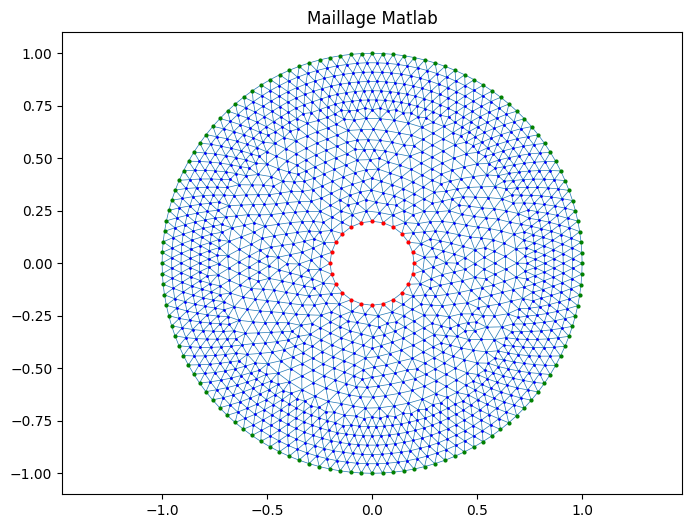

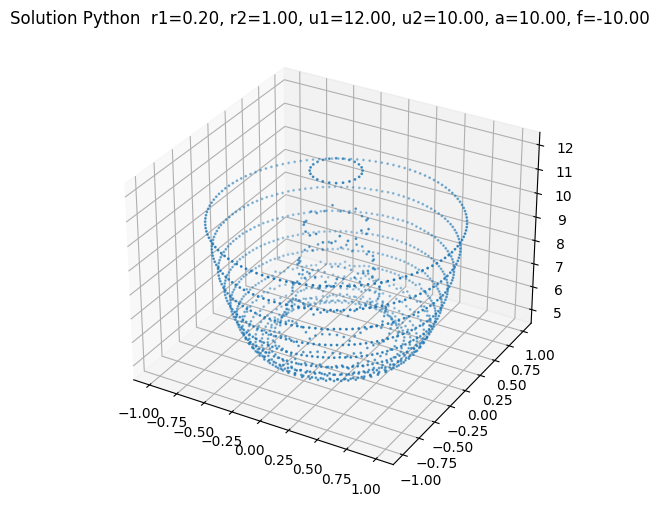

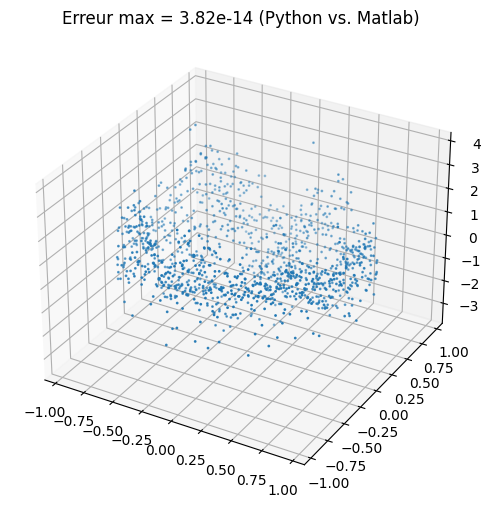

In [ ]:
coaxial_matl()

## Maillage circulaire en Python

Paramètres
r1=0.20, r2=1.00, u1=12.00, u2=10.00, a=10.00, f=-10.00
Construction du maillage
Génération des listes
Génération des matrices de masse et de rigidité
Résolution du système linéaire
Tracé de la solution


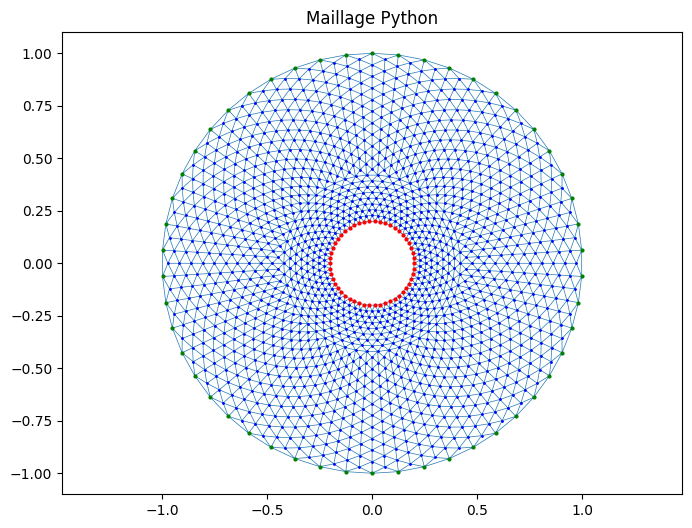

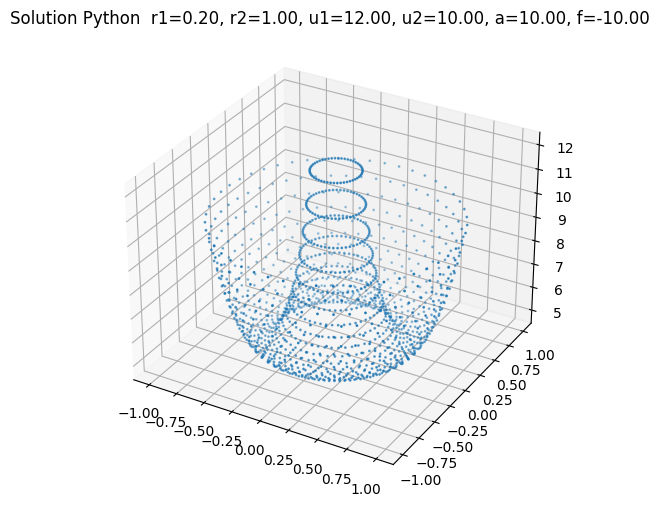

In [ ]:
coaxial_circ()

## Maillage hexagonal en Python

Paramètres
r1=0.20, r2=1.00, u1=12.00, u2=10.00, a=10.00, f=-10.00
Construction du maillage
Génération des listes
Génération des matrices de masse et de rigidité
Résolution du système linéaire
Tracé de la solution


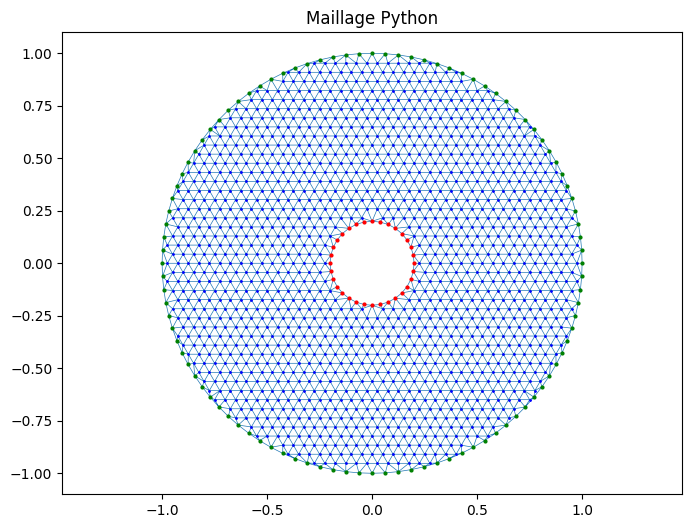

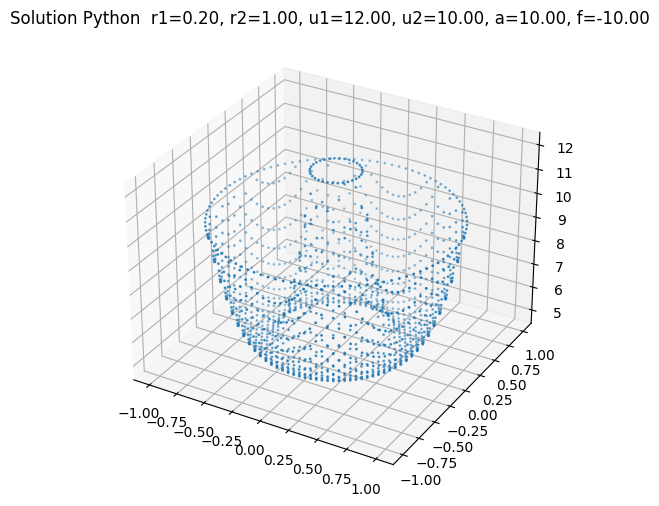

In [ ]:
coaxial_hexa()